# Телеком

## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 
##### Ваша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Описание услуг

Оператор предоставляет два основных типа услуг:
* Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
* Интернет. 
Подключение бывает двух типов: через телефонную линию DSL (англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
* Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
* Выделенная линия технической поддержки (Tech Support);
* Облачное хранилище файлов для резервного копирования данных (Online Backup);
* Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

## Описание данных

#### Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:

* contract — информация о договорах;
* personal — персональные данные клиентов;
* internet — информация об интернет-услугах;
* phone — информация об услугах телефонии.

#### Таблица telecom.contract
* customerID — ID абонента;
* BeginDate — дата начала действия договора;
* EndDate — дата окончания действия договора;
* Type — тип оплаты: раз в год-два или ежемесячно;
* PaperlessBilling — электронный расчётный лист;
* PaymentMethod — тип платежа;
* MonthlyCharges — расходы за месяц;
* TotalCharges — общие расходы абонента.

#### Таблица personal
* customerID — ID пользователя;
* gender — пол;
* SeniorCitizen — является ли абонент пенсионером;
* Partner — есть ли у абонента супруг или супруга;
* Dependents — есть ли у абонента дети.

#### Таблица telecom.internet
* customerID — ID пользователя;
* InternetService — тип подключения;
* OnlineSecurity — блокировка опасных сайтов;
* OnlineBackup — облачное хранилище файлов для резервного копирования данных;
* DeviceProtection — антивирус;
* TechSupport — выделенная линия технической поддержки;
* StreamingTV — стриминговое телевидение;
* StreamingMovies — каталог фильмов.

#### Таблица telecom.phone
* customerID — ID пользователя;
* MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

## Подключимся к базе. Загрузим таблицы sql

In [1]:
#Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import scipy.stats as ss
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import re
import transformers
import sys
import os
import torchvision.models as models
import tensorflow as tf
import nltk
import phik
import lightgbm as lgb

from phik.report import plot_correlation_matrix
from phik import report
from nltk.corpus import stopwords
from sklearn.linear_model import Ridge

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from datetime import datetime

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState
from sklearn.metrics import precision_score, recall_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, accuracy_score, make_scorer, precision_recall_curve, auc
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sqlalchemy import create_engine
from sklearn.naive_bayes import GaussianNB
from torch.utils.data import Dataset, DataLoader
from sklearn.compose import make_column_transformer, make_column_selector
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve

from tqdm import notebook
from tqdm.notebook import tqdm
tqdm.pandas()

import random
import warnings
warnings.filterwarnings('ignore')

tqdm.pandas()
plt.style.use('ggplot')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <9A4710B9-0DA3-36BB-9129-645F282E64B2> /opt/homebrew/anaconda3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <DB251723-D0A7-3D18-91AD-79131BDBDDBC> /opt/homebrew/anaconda3/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
RANDOM_STATE = 260623

In [3]:
# Объявим конфигурацию для подключения к серверу.
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-final' # название базы данных,
} 

# Формируем строку для подключения.
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db']
)

# Создадим соединение.
engine = create_engine(connection_string)

Настройки подключения готовы

## Проведем исследовательский анализ и предобработку данных

Сначала осмотрим сами таблицы и выведим общие данные

In [4]:
# Посмотрим на размер нашей БД
query = '''
SELECT pg_size_pretty(pg_database_size(current_database()));
'''
df = pd.read_sql_query(query, con=engine)
df

,pg_size_pretty
0,13 MB


In [5]:
# Посмотрим названия таблиц в БД
query = '''
SELECT table_name
  FROM information_schema.tables
 WHERE table_schema NOT IN ('information_schema','pg_catalog');
'''
df = pd.read_sql_query(query, con=engine)
df

,table_name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_gas
4,data_temp
5,data_wire
6,data_wire_time
7,personal
8,phone
9,contract


База данных показывает, что есть еще таблицы, не считая тех 4 указанных в описании. Скорее всего это административные таблицы и нас они не интересуют. Поэтому на наличие и соответствие описанию проверим только 4 (contract; personal; internet; phone)

In [6]:
# Посмотрим какие колонки имеются в наших таблицах и какой тип данных они имеют.
query = '''
SELECT table_name, 
       column_name, 
       data_type 
  FROM information_schema.columns
 WHERE table_name IN ('personal', 'phone', 'contract', 'internet');
'''
df = pd.read_sql_query(query, con=engine)
df

,table_name,column_name,data_type
0,personal,customerID,text
1,personal,gender,text
2,personal,SeniorCitizen,integer
3,personal,Partner,text
4,personal,Dependents,text
5,phone,c1,text
6,phone,c2,text
7,contract,customerID,text
8,contract,BeginDate,date
9,contract,EndDate,date


### Выведем теперь подробную информацию о таблицах

### contract

In [7]:
# contract
contract = '''
SELECT *
FROM telecom.contract
'''
contract = pd.read_sql_query(contract, con = engine)
print('Первые 20 строк таблицы contract:')
display(contract.head(20))
print('Информация о таблице contract:')
print(contract.info())

Первые 20 строк таблицы contract:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
8,7892-POOKP,2019-04-27,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN


Информация о таблице contract:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB
None


#### Вывод
* В таблице contract содержится информация о 7043 абонентах.

* Есть пропущенные значения в столбцах EndDate (дата окончания действия договора) и TotalCharges (общие расходы абонента).

* Столбец BeginDate и EndDate имеют тип object. Вероятно, для дальнейшего анализа необходимо преобразовать их в тип даты.

* Столбцы PaperlessBilling, Type, PaymentMethod имеют тип object, что указывает на использование категориальных переменных. 
Возможно, для анализа этих переменных потребуется преобразование в соответствующий формат.

* Столбцы MonthlyCharges (расходы за месяц) и TotalCharges (общие расходы абонента) имеют тип float64.

In [8]:
#Проверим наличие пропущенных значений:
contract.isnull().sum()   

customerID             0
BeginDate              0
EndDate             5174
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
dtype: int64

Количество пропущенных значений в EndDate - огромно, поэтому сначала посмотрим TotalCharges

In [9]:
contract.loc[contract.TotalCharges.isna()==True, :]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN


Исходя из предоставленной информации, можно сделать вывод, что пользователи заключили договор в дату выгрузки данных, но скорее всего, им еще не были начислены платежи или эта информация не была внесена в базу данных.

Учитывая, что данные пользователей без информации о дате окончания и общей сумме платежей составляют небольшую часть от общего объема данных, предлагаю удалить эти данные из анализа. Их удаление обусловлено тем, что эти записи не несут существенной информации о вероятности ухода потребителя, поскольку пользователи могли отказаться от услуг компании уже на следующий день после даты выгрузки, даже если они заплатили за услуги.

Таким образом, удаление этих записей из рассмотрения позволит сосредоточиться на более информативных данных и получить более точные результаты анализа. Однако сделаем это после объединения таблиц

Что касается EndDate, в данном случае замена пропущенных значений в данном столбце нецелесообразна, поскольку целевая переменная для прогнозирования оттока клиентов является датой окончания договора. Замена пропусков может исказить данные и внести неправильные предположения о времени окончания договора.

Вместо замены пропущенных значений в столбце "EndDate" можно использовать столбец "EndDate" как категориальную переменную, где пропущенное значение будет отражать активное состояние договора (клиенты, которые еще не разорвали договор). В этом случае, при обучении модели, можно преобразовать столбец "EndDate" в двоичный признак, где 1 будет указывать на активный договор, а 0 - на разорванный договор.

In [10]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


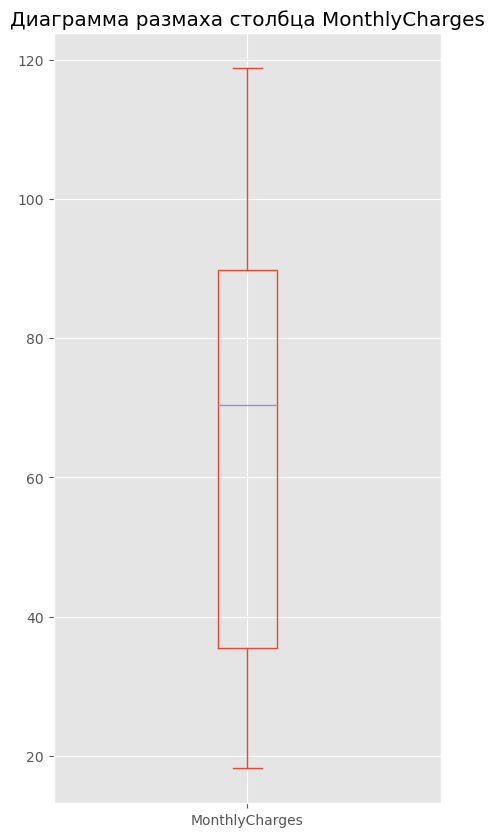

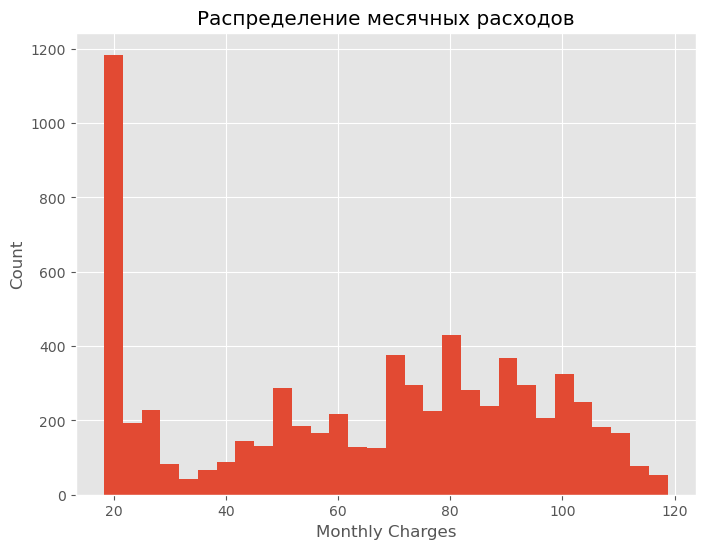

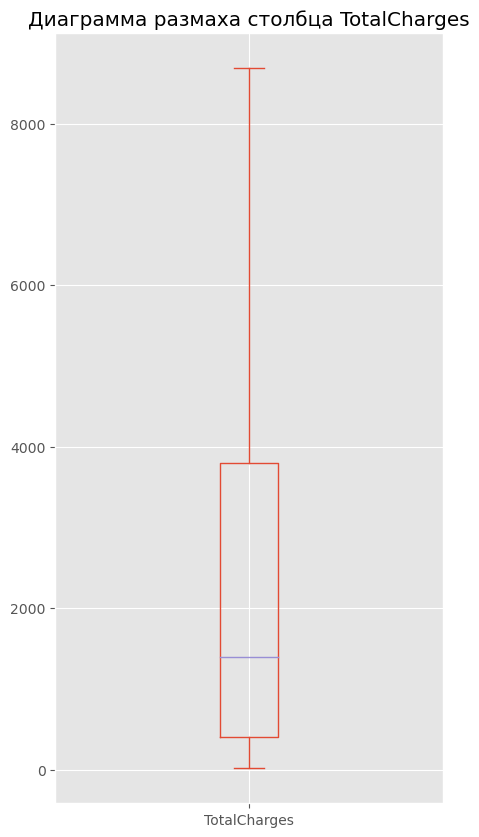

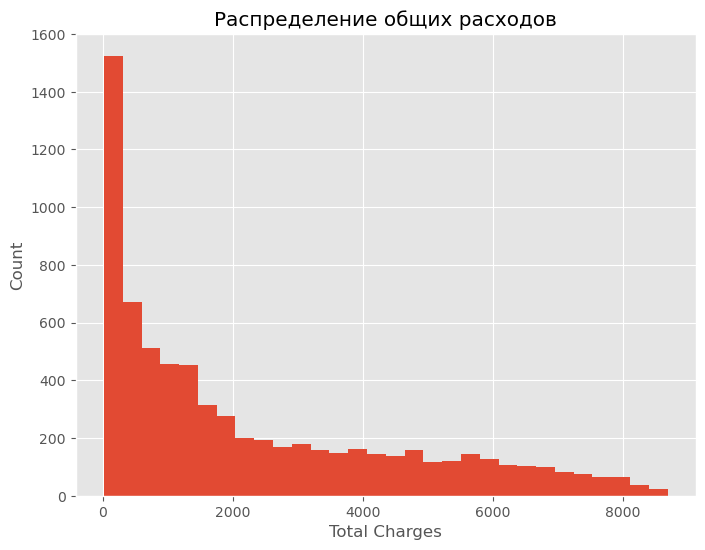

In [11]:
# Изучим распределение признаков:

# Диаграмма размаха для столбца MonthlyCharges
contract['MonthlyCharges'].plot(kind='box', figsize=(5, 10), grid=True, legend=True, title='Диаграмма размаха столбца MonthlyCharges')

# Гистограмма распределения месячных расходов
plt.figure(figsize=(8, 6))
plt.hist(contract['MonthlyCharges'], bins=30)
plt.xlabel('Monthly Charges')
plt.ylabel('Count')
plt.title('Распределение месячных расходов')
plt.show()

# Диаграмма размаха для столбца TotalCharges
contract['TotalCharges'].plot(kind='box', figsize=(5, 10), grid=True, legend=True, title='Диаграмма размаха столбца TotalCharges')

# Гистограмма распределения общих расходов
plt.figure(figsize=(8, 6))
plt.hist(contract['TotalCharges'], bins=30)
plt.xlabel('Total Charges')
plt.ylabel('Count')
plt.title('Распределение общих расходов')
plt.show()


#### Вывод
Среднее значение MonthlyCharges составляет около 64.8, с некоторым разбросом в данных. Минимальное значение - 18.3, а максимальное - 118.8.

Среднее значение TotalCharges составляет около 2283.3, с большим разбросом в данных. Минимальное значение общих расходов составляет 18.8, а максимальное - 8684.8.

Распределение месячных расходов (MonthlyCharges) и общих расходов (TotalCharges) имеет широкий диапазон значений и показывает наличие выбросов в сторону более высоких расходов.

Медианное значение как месячных расходов (70.4) так и общих расходов (1397.5), означает, что половина клиентов имеют месячные/общие расходы выше этого значения, а половина - ниже.

Еще можно добавить следующее:

По гистограммам видно, что распределение месячных расходов MonthlyCharges не является нормальным. Это может означать, что есть различные группы клиентов, платящих разные суммы в месяц, что может быть связано с различными пакетами услуг, которые они используют.

Распределение общих расходов TotalCharges смещено вправо. Это может быть связано с тем, что у нас есть клиенты, которые являются пользователями на протяжении длительного времени и, следовательно, имеют более высокие общие расходы.

In [12]:
# Посмотрим на уникальные значения категориальных признаков
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod']

for feature in categorical_features:
    unique_values = contract[feature].unique()
    print(f"Уникальные значения для признака {feature}:")
    print(unique_values)
    print()

Уникальные значения для признака Type:
['Two year' 'Month-to-month' 'One year']

Уникальные значения для признака PaperlessBilling:
['Yes' 'No']

Уникальные значения для признака PaymentMethod:
['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']



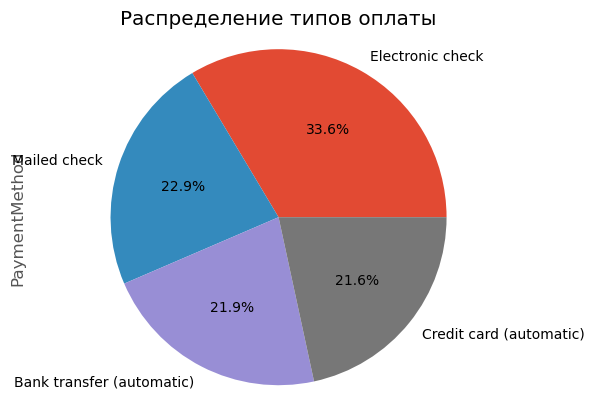

In [13]:
# Круговая диаграмма типов оплаты
contract['PaymentMethod'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.axis('equal')
plt.title('Распределение типов оплаты')
plt.show()

#### Вывод
Видно, что количество оплат электронным чеком чуть выше(33,6%), чем остальные виды платежей

In [14]:
# преобразование столбца BeginDate в тип даты to_datetime
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

In [15]:
#Проверим, нет ли дубликатов в первичном ключе - customerID.
contract.customerID.duplicated().sum()

0

### personal

In [16]:
# personal
personal = '''
SELECT *
FROM telecom.personal
'''
personal = pd.read_sql_query(personal, con = engine)
print('Первые 20 строк таблицы personal:')
display(personal.head(20))
print('Информация о таблице personal:')
print(personal.info())

Первые 20 строк таблицы personal:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


Информация о таблице personal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


In [17]:
#Проверка наличия пропущенных значений
missing_values = personal.isnull().sum()
print("Пропущенные значения в каждом столбце:")
print(missing_values)

Пропущенные значения в каждом столбце:
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


Распределение клиентов по полу:
Male      3555
Female    3488
Name: gender, dtype: int64
Распределение пожилых клиентов:
0    5901
1    1142
Name: SeniorCitizen, dtype: int64


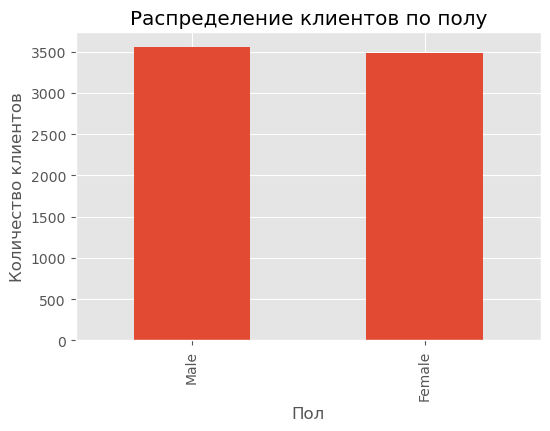

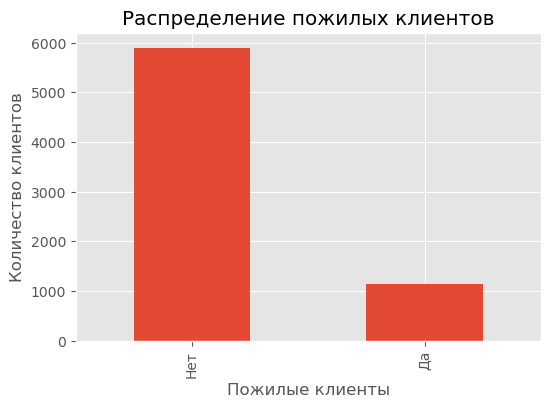

In [18]:
# Изучим распределение признаков

# Количество клиентов по полу
gender_counts = personal['gender'].value_counts()
print("Распределение клиентов по полу:")
print(gender_counts)

# Количество пожилых клиентов
senior_counts = personal['SeniorCitizen'].value_counts()
print("Распределение пожилых клиентов:")
print(senior_counts)

# Гистограмма распределения клиентов по полу
plt.figure(figsize=(6, 4))
personal['gender'].value_counts().plot(kind='bar')
plt.xlabel('Пол')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по полу')
plt.show()

# Гистограмма распределения пожилых клиентов
plt.figure(figsize=(6, 4))
personal['SeniorCitizen'].value_counts().plot(kind='bar')
plt.xlabel('Пожилые клиенты')
plt.ylabel('Количество клиентов')
plt.title('Распределение пожилых клиентов')
plt.xticks([0, 1], ['Нет', 'Да'])
plt.show()


#### Вывод
Из анализа распределения клиентов по полу видно, что в выборке примерно равное количество мужчин и женщин. Количество мужчин составляет 3555, а количество женщин - 3488.

Относительно пожилых клиентов, в выборке явно пожилых людей гораздо меньше (1142 против и 5901).

### internet

In [19]:
# internet
internet = '''
SELECT *
FROM telecom.internet
'''
internet = pd.read_sql_query(internet, con = engine)
print('Первые 20 строк таблицы internet:')
display(internet.head(20))
print('Информация о таблице internet:')
print(internet.info())

Первые 20 строк таблицы internet:


,c1,c2,c3,c4,c5,c6,c7,c8
0,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
8,6713-OKOMC,DSL,Yes,No,No,No,No,No
9,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


Информация о таблице internet:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5518 entries, 0 to 5517
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      5518 non-null   object
 1   c2      5518 non-null   object
 2   c3      5518 non-null   object
 3   c4      5518 non-null   object
 4   c5      5518 non-null   object
 5   c6      5518 non-null   object
 6   c7      5518 non-null   object
 7   c8      5518 non-null   object
dtypes: object(8)
memory usage: 345.0+ KB
None


In [20]:
# Замена названий столбцов
new_columns = internet.iloc[0]
internet = internet[1:].rename(columns=new_columns)

# Проверка изменений
print('Первые 5 строк таблицы internet после замены названий столбцов:')
display(internet.head())

Первые 5 строк таблицы internet после замены названий столбцов:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [21]:
missing_values = internet.isnull().sum()
print("Пропущенные значения в каждом столбце:")
print(missing_values)

Пропущенные значения в каждом столбце:
customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


In [22]:
# посмотрим уникальные значения категориальных признаков
categorical_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in categorical_columns:
    unique_values = internet[column].unique()
    print(f"Уникальные значения в столбце {column}:")
    print(unique_values)
    print()

Уникальные значения в столбце InternetService:
['DSL' 'Fiber optic']

Уникальные значения в столбце OnlineSecurity:
['No' 'Yes']

Уникальные значения в столбце OnlineBackup:
['Yes' 'No']

Уникальные значения в столбце DeviceProtection:
['No' 'Yes']

Уникальные значения в столбце TechSupport:
['No' 'Yes']

Уникальные значения в столбце StreamingTV:
['No' 'Yes']

Уникальные значения в столбце StreamingMovies:
['No' 'Yes']



### phone

In [23]:
# phone
phone = '''
SELECT *
FROM telecom.phone
'''
phone = pd.read_sql_query(phone, con = engine)
print('Первые 20 строк таблицы phone:')
display(phone.head(20))
print('Информация о таблице phone:')
print(phone.info())

Первые 20 строк таблицы phone:


,c1,c2
0,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No
8,9763-GRSKD,No
9,7469-LKBCI,No


Информация о таблице phone:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   c1      6362 non-null   object
 1   c2      6362 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


In [24]:
# Замена названий столбцов
new_columns = phone.iloc[0]
phone = phone[1:].rename(columns=new_columns)

# Проверка изменений
print('Первые 5 строк таблицы internet после замены названий столбцов:')
display(phone.head())

Первые 5 строк таблицы internet после замены названий столбцов:


,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes


In [25]:
unique_values = phone['MultipleLines'].unique()
print("Уникальные значения в столбце 'MultipleLines':")
print(unique_values)

Уникальные значения в столбце 'MultipleLines':
['No' 'Yes']


#### Вывод

Нам удалось установить связь с базой данных (База данных показывает, что есть еще таблицы, не считая тех 4 указанных в описании. Скорее всего это административные таблицы и нас они не интересуют) и вытащить из неё 4 таблицы. Общий размер БД 13 Mb

* contract — информация о договорах. 

**Всего наблюдений по контрактам у нас 7043. 

**Исходя из полученной информации было принято решение удалить данные пользователей без информации о дате окончания и общей сумме платежей (TotalCharges ), которые составляют небольшую часть от общего объема данных. Их удаление обусловлено тем, что эти записи не несут существенной информации о вероятности ухода потребителя, поскольку пользователи могли отказаться от услуг компании уже на следующий день после даты выгрузки, даже если они заплатили за услуги. 

**Вместо замены пропущенных значений в столбце "EndDate" используем столбец "EndDate" как категориальную переменную, где пропущенное значение будет отражать активное состояние договора (клиенты, которые еще не разорвали договор). В этом случае, при обучении модели, можно преобразовать столбец "EndDate" в двоичный признак, где 1 будет указывать на активный договор, а 0 - на разорванный договор. 

**Среднее значение MonthlyCharges составляет около 64.8, с некоторым разбросом в данных. Минимальное значение - 18.3, а максимальное - 118.8. Среднее значение TotalCharges составляет около 2283.3, с большим разбросом в данных. Минимальное значение общих расходов составляет 18.8, а максимальное - 8684.8. Распределение месячных расходов (MonthlyCharges) и общих расходов (TotalCharges) имеет широкий диапазон значений и показывает наличие выбросов в сторону более высоких расходов. Медианное значение как месячных расходов (70.4) так и общих расходов (1397.5), означает, что половина клиентов имеют месячные/общие расходы выше этого значения, а половина - ниже.

* personal — персональные данные клиентов. Здесь также 7043, что очевидно (1 пользователь - 1 контракт). Пропущенные значения отсутствуют

* internet — информация об интернет-услугах. Всего 5518 наблюдений и 8 признаков. Пропущенных значений нет, переименовала столбцы.

* phone — информация об услугах телефонии. Он предоставляет нам 6363 наблюдения и всего 2 столбца. Пропущенных значений нет, переименовала столбцы.

## Объединим таблицы по ID клиента

In [26]:
merged_df = personal.merge(contract, on ='customerID', how='inner')
merged_df = merged_df.merge(internet, on ='customerID', how = 'outer')
merged_df = merged_df.merge(phone, on ='customerID', how = 'outer')

In [27]:
#Проверим
merged_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,None,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,None,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,None,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No


In [28]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   gender            7043 non-null   object        
 2   SeniorCitizen     7043 non-null   int64         
 3   Partner           7043 non-null   object        
 4   Dependents        7043 non-null   object        
 5   BeginDate         7043 non-null   datetime64[ns]
 6   EndDate           1869 non-null   object        
 7   Type              7043 non-null   object        
 8   PaperlessBilling  7043 non-null   object        
 9   PaymentMethod     7043 non-null   object        
 10  MonthlyCharges    7043 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup      5517 n

#### Вывод
Всего в таблице 7043 строк и 20 столбцов. С пропусками из TotalCharges описано выше. Остальные пропуски связаны интернетом и телефонной связью

### Предобработка данных

Сгенерируем новые признаки, которые могут пригодиться при обучении. 

In [29]:
#Рассчитаем длительность контракта абонента

# Преобразование столбца EndDate в формат даты
merged_df['EndDate'] = pd.to_datetime(merged_df['EndDate'])

# Расчет длительности контракта
current_date = datetime.now()
merged_df['ContractDuration'] = (merged_df['EndDate'] - merged_df['BeginDate']).dt.days

# Замена пропущенных значений в ContractDuration на текущую длительность контракта
merged_df['ContractDuration'].fillna((current_date - merged_df['BeginDate']).dt.days, inplace=True)

In [30]:
# Создадим бинарный признак HasPhoneService, указывающий, есть ли у клиента услуга стационарной телефонной связи
merged_df['HasPhoneService'] = merged_df['MultipleLines'].apply(lambda x: 0 if x == 'No' else 1)

In [31]:
# Создадим бинарный признак HasInternetService, указывающий, есть ли у клиента услуга интернета.
merged_df['HasInternetService'] = merged_df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)

Выделим в целевую переменную признак EndDate.

In [32]:
# Создание столбца 'Churn' в качестве целевой переменной
merged_df['Churn'] = merged_df['EndDate'].isnull().astype(int)

Теперь у нас есть новый столбец Churn, который содержит значения 1 - для активных клиентов (договор еще не разорван) и значения 0 - для клиентов с разорванным договором.

In [33]:
# Переведем 'SeniorCitizen' в тип object
merged_df['SeniorCitizen'] = merged_df['SeniorCitizen'].astype(str)

In [34]:
# посмотрим на результат
print(merged_df.head(10))
print(merged_df.info())

   customerID  gender SeniorCitizen Partner Dependents  BeginDate    EndDate  \
0  7590-VHVEG  Female             0     Yes         No 2019-04-29        NaT   
1  5575-GNVDE    Male             0      No         No 2019-03-26        NaT   
2  3668-QPYBK    Male             0      No         No 2018-08-09 2019-12-01   
3  7795-CFOCW    Male             0      No         No 2018-12-22        NaT   
4  9237-HQITU  Female             0      No         No 2019-01-26 2019-11-01   
5  9305-CDSKC  Female             0      No         No 2018-12-26 2019-11-01   
6  1452-KIOVK    Male             0      No        Yes 2018-12-20        NaT   
7  6713-OKOMC  Female             0      No         No 2019-02-05        NaT   
8  7892-POOKP  Female             0     Yes         No 2019-04-27 2019-11-01   
9  6388-TABGU    Male             0      No        Yes 2018-12-17        NaT   

             Type PaperlessBilling              PaymentMethod  ...  \
0  Month-to-month              Yes           Elec

После выполнения преобразований, мы видим следующие изменения:

Столбец "EndDate" был преобразован в формат даты и содержит значения дат окончания контрактов.

Были добавлены новые признаки:

- "ContractDuration", который представляет собой длительность контракта в днях.
- "HasPhoneService" (бинарный признак), указывающий, есть ли у клиента услуга стационарной телефонной связи.
- "HasInternetService" (бинарный признак), указывающий, есть ли у клиента услуга интернета.

Согласно заданию и для анализа, проработаем пропуски

Для столбцов с категориальными данными, такими как "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies" и "MultipleLines", можно заполнить пропущенные значения наиболее часто встречающимся значением.

In [35]:
categorical_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for column in categorical_columns:
    merged_df[column].fillna(merged_df[column].mode()[0], inplace=True)

In [36]:
# Удалим 11 записей с пропущенными значениями в столбце 'TotalCharges',
merged_df.dropna(subset=['TotalCharges'], inplace=True)

In [37]:
# Т.к. '01-02-2020' - дата выгрузки базы данных, то заполним Nan в колонке 'EndDate' этой датой
end_date_fill_value = pd.to_datetime('01-02-2020', dayfirst=True)
merged_df['EndDate'].fillna(end_date_fill_value, inplace=True)


In [38]:
# Проверим результат
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customerID          7032 non-null   object        
 1   gender              7032 non-null   object        
 2   SeniorCitizen       7032 non-null   object        
 3   Partner             7032 non-null   object        
 4   Dependents          7032 non-null   object        
 5   BeginDate           7032 non-null   datetime64[ns]
 6   EndDate             7032 non-null   datetime64[ns]
 7   Type                7032 non-null   object        
 8   PaperlessBilling    7032 non-null   object        
 9   PaymentMethod       7032 non-null   object        
 10  MonthlyCharges      7032 non-null   float64       
 11  TotalCharges        7032 non-null   float64       
 12  InternetService     7032 non-null   object        
 13  OnlineSecurity      7032 non-null   object      

### Визуализируем распределение каждого признака

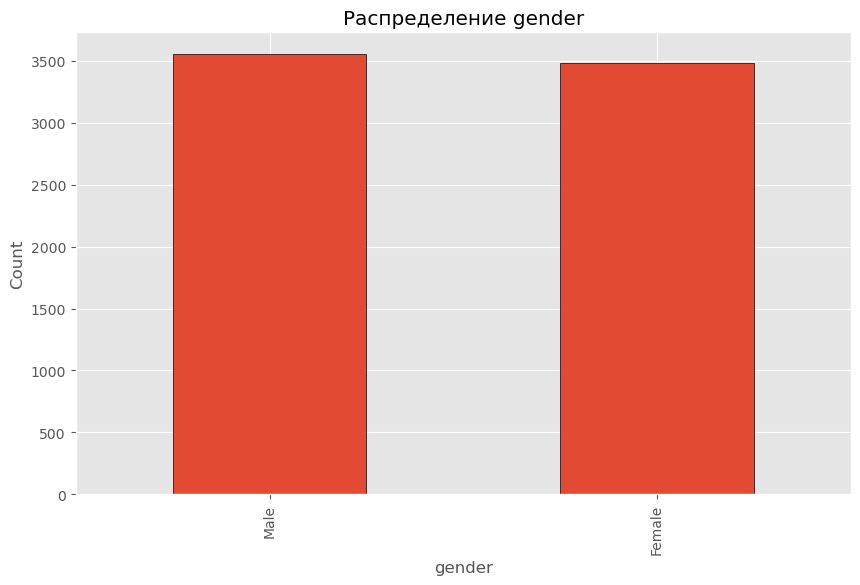

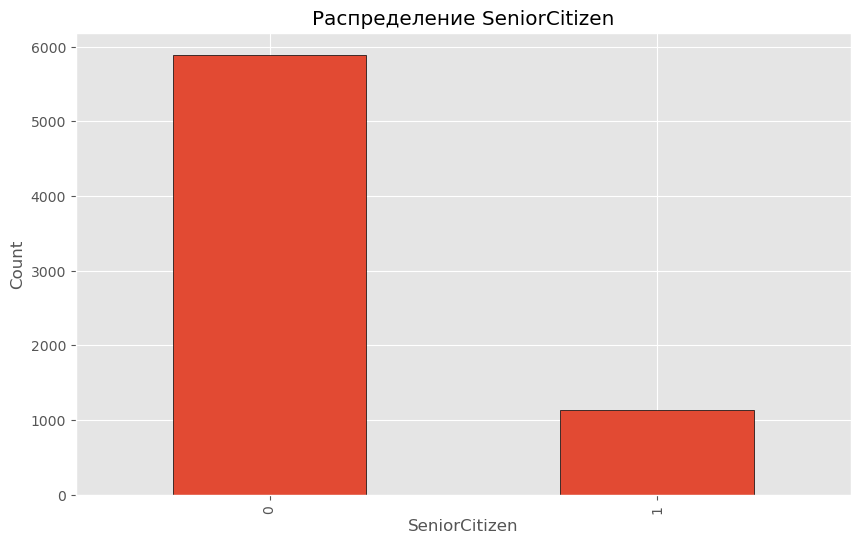

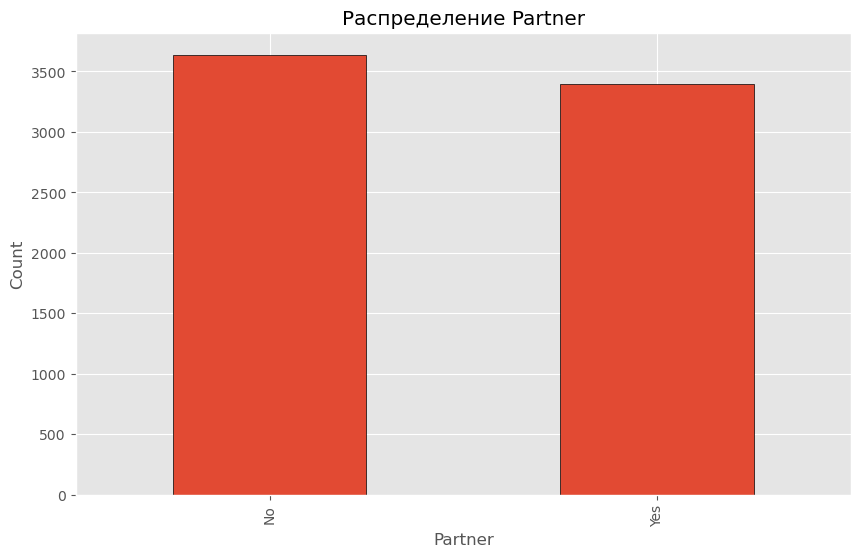

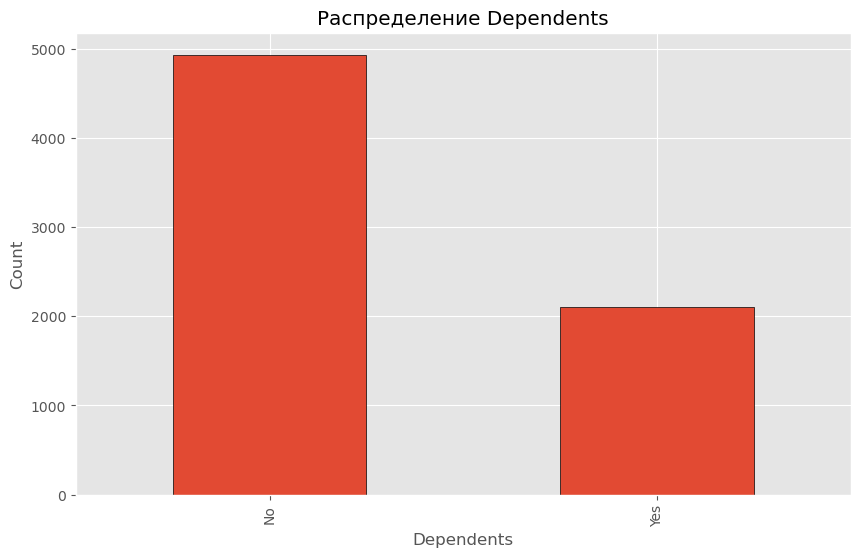

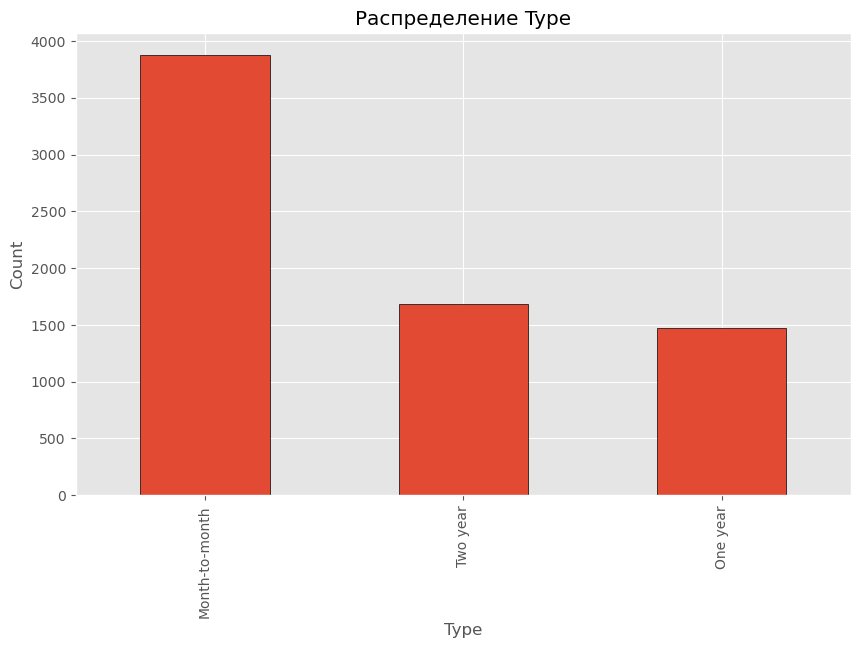

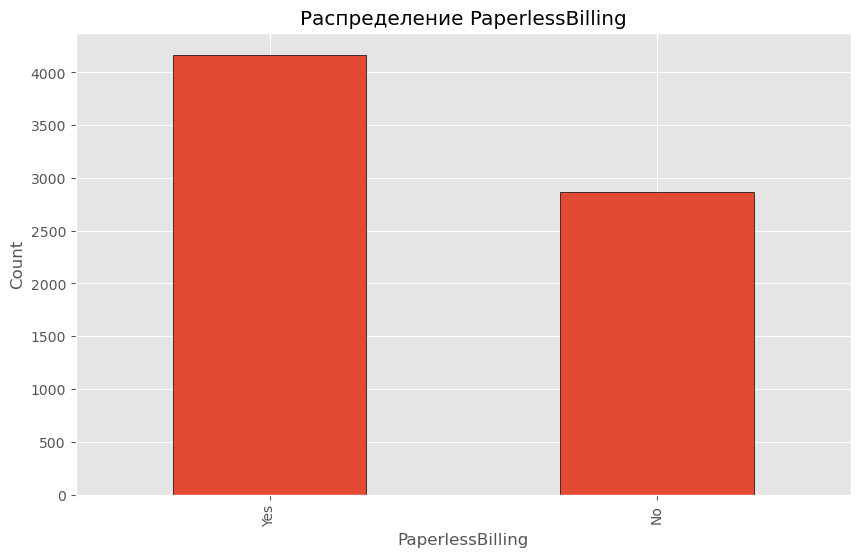

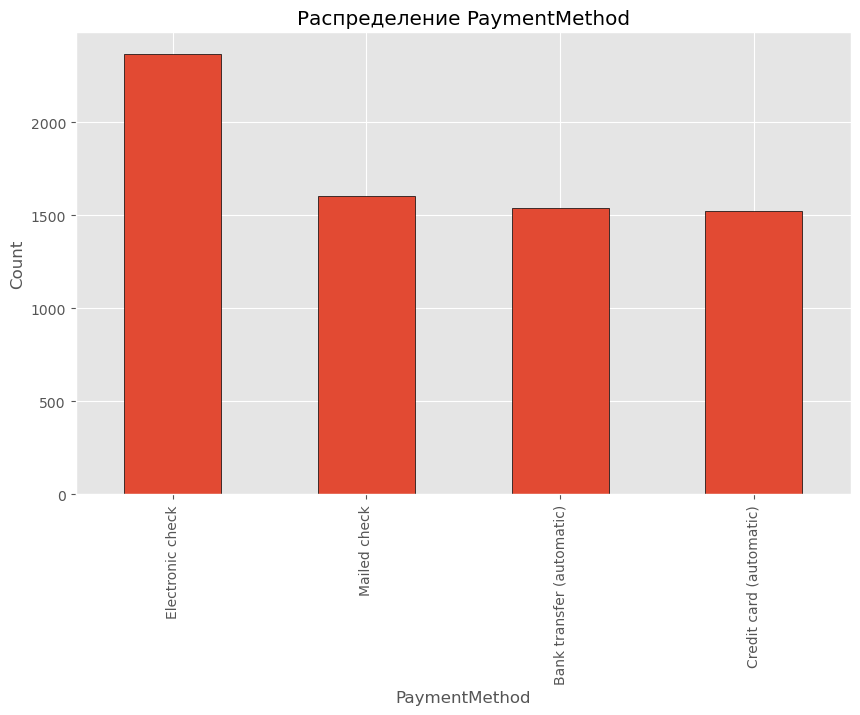

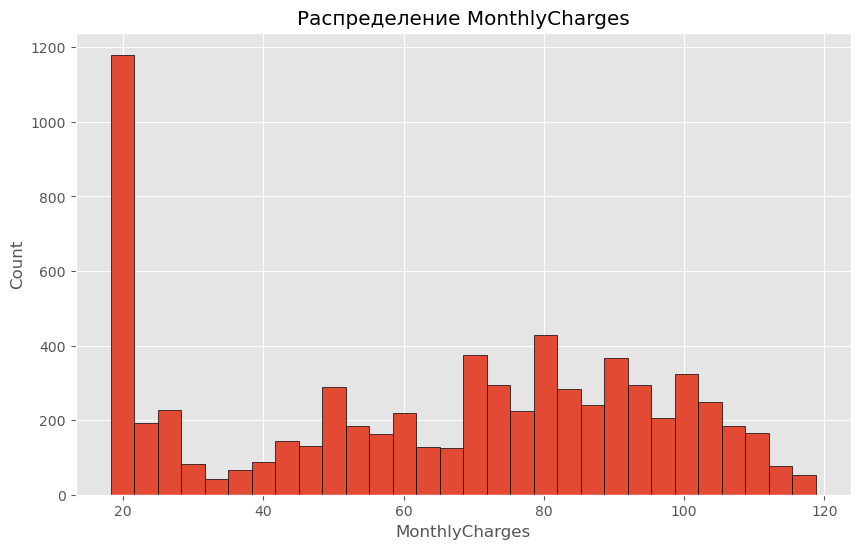

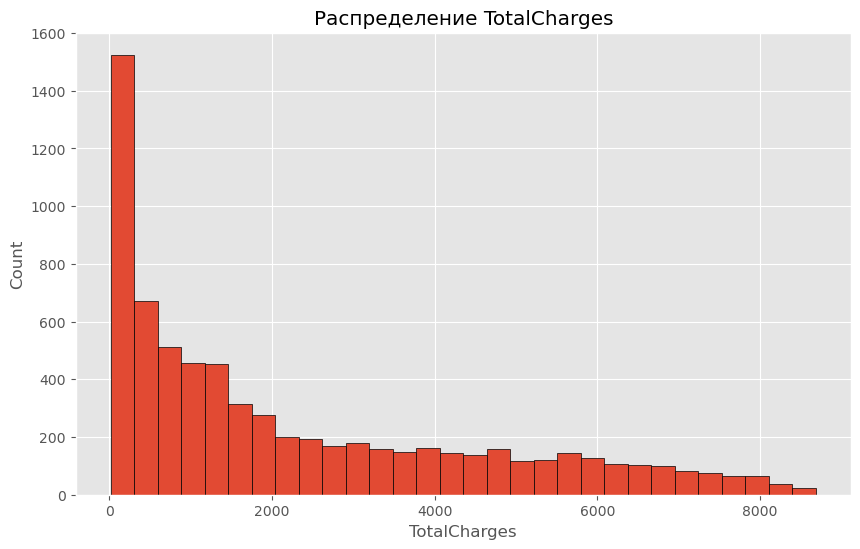

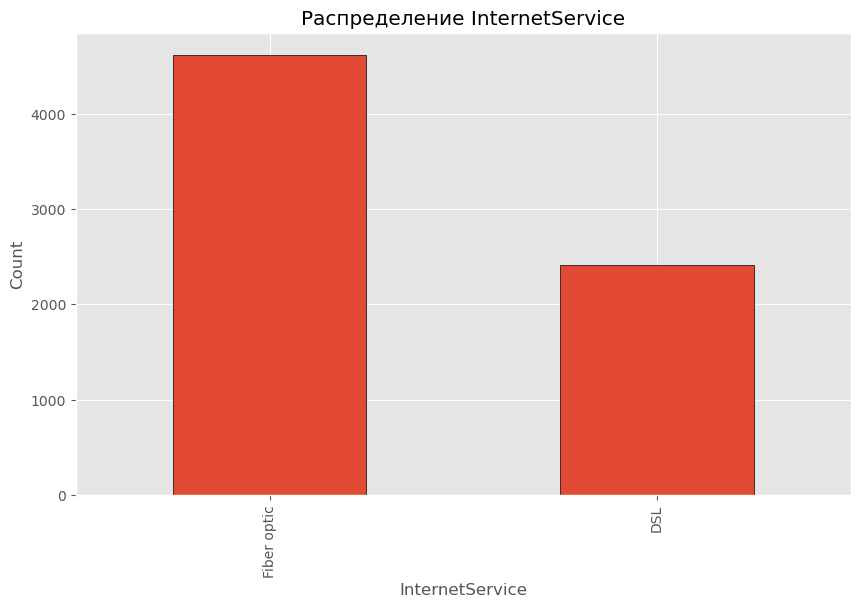

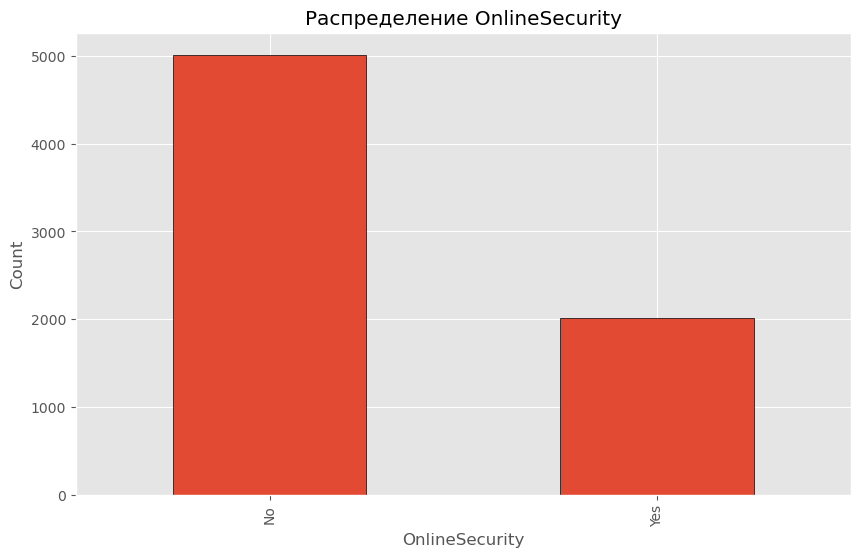

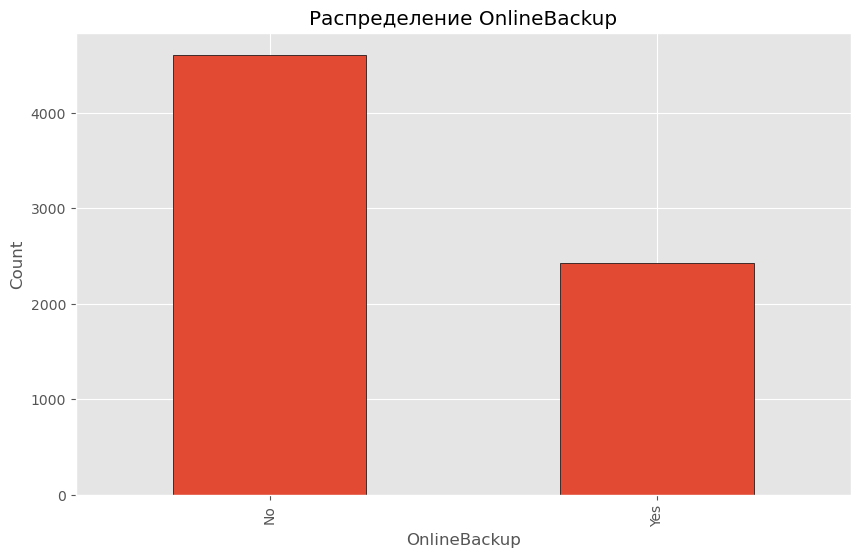

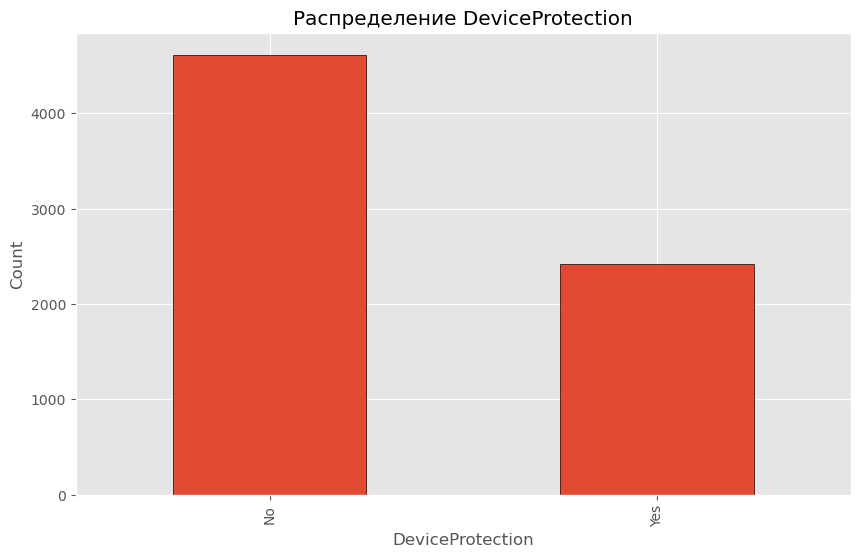

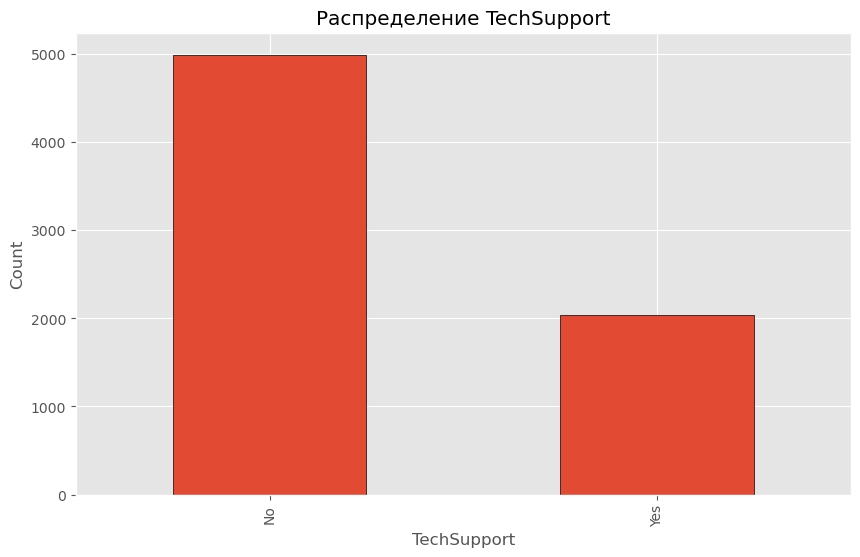

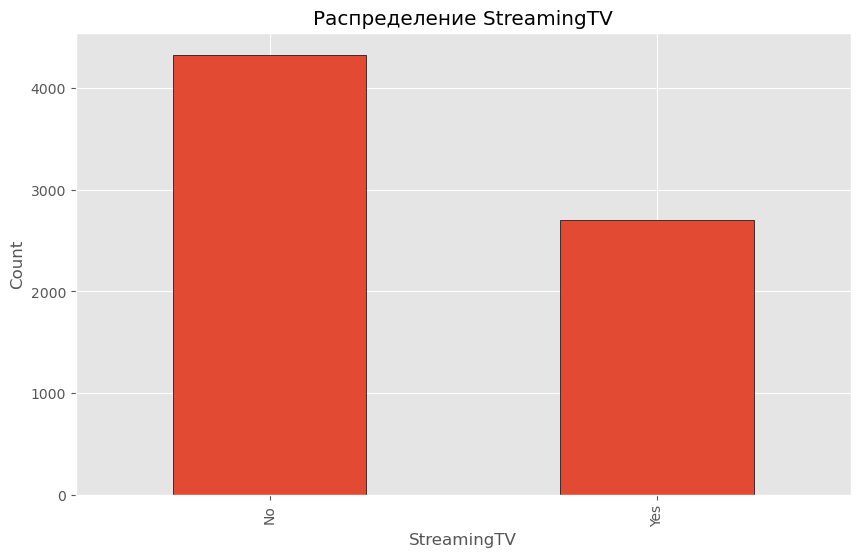

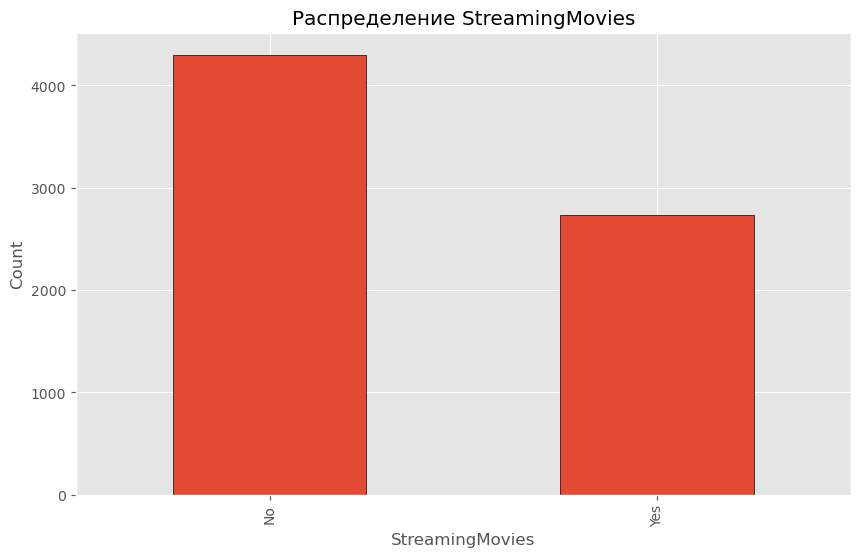

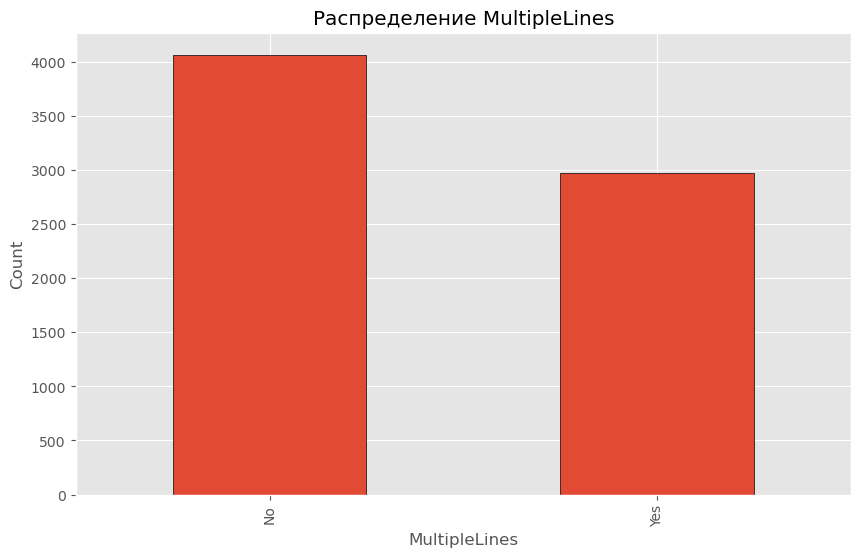

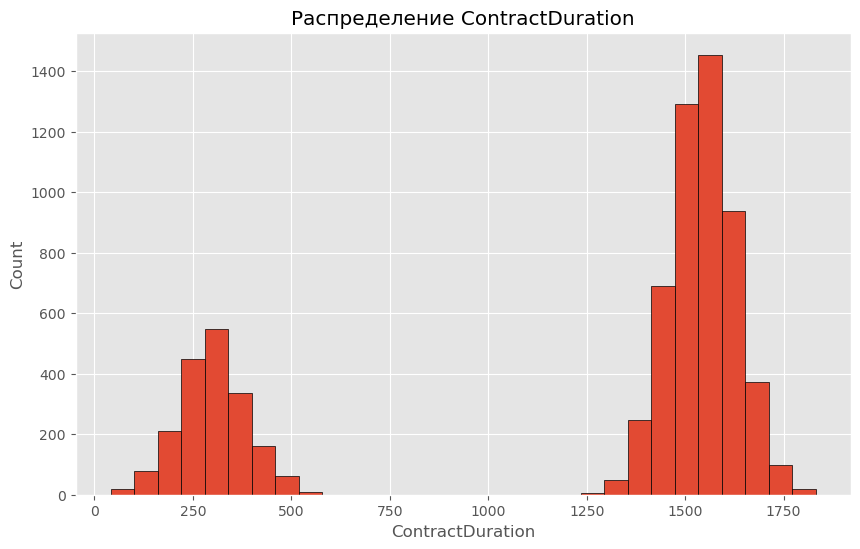

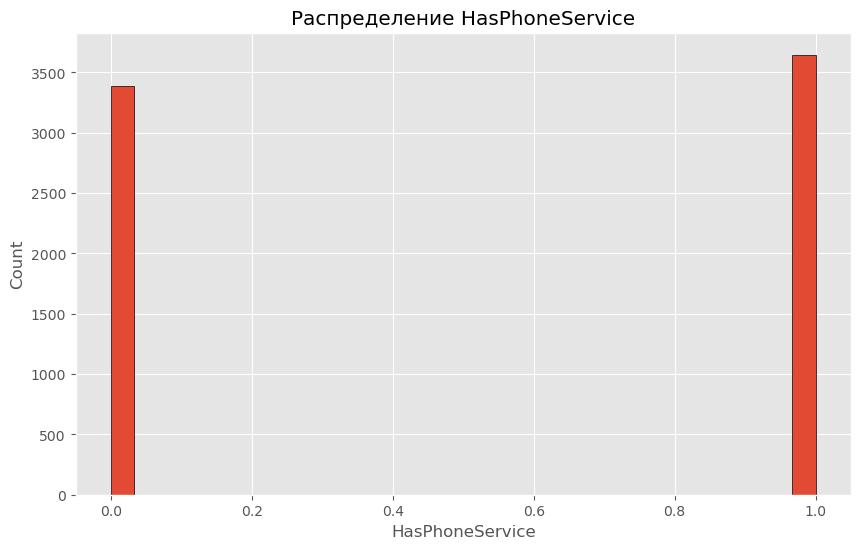

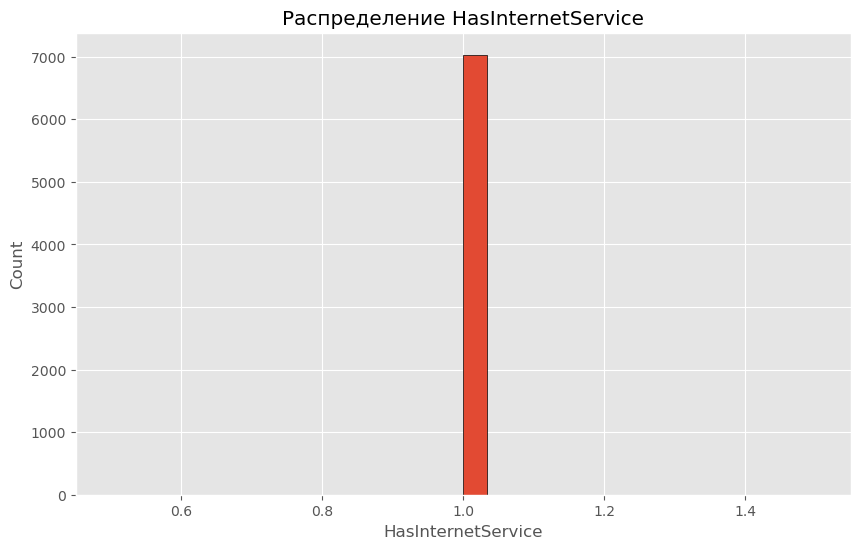

In [39]:
# Список признаков для визуализации
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'MultipleLines', 'ContractDuration', 'HasPhoneService', 
        'HasInternetService']

# Визуализация распределения каждого признака
for feature in features:
    if merged_df[feature].dtype == 'object':
        # Категориальный признак - используем столбчатую диаграмму
        plt.figure(figsize=(10, 6))
        merged_df[feature].value_counts().plot(kind='bar', edgecolor='k')
        plt.title(f'Распределение {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.show()
    else:
        # Числовой признак - используем гистограмму
        plt.figure(figsize=(10, 6))
        plt.hist(merged_df[feature].dropna(), bins=30, edgecolor='k')
        plt.title(f'Распределение {feature}')
        plt.xlabel(feature)
        plt.ylabel('Count')
        plt.show()


#### Дадим краткое описание каждому из признаков согласно их визуализации:
- Gender: Распределение между мужчинами и женщинами примерно одинаковое.

- SeniorCitizen: Большинство пользователей (около 83.8%) не относятся к пожилым.

- Partner: Распределение между пользователями, имеющими и не имеющими супругов, примерно одинаковое.

- Dependents: Большинство пользователей (около 70.2%) не имеют детей.

- Type: Большинство пользователей (около 55%) выбирают контракты с оплатой "Month-to-month".

- PaperlessBilling: Большинство пользователей (около 59.3%) предпочитают электронный расчётный лист.

- PaymentMethod: Электронный чек является наиболее популярным способом оплаты, но распределение между различными методами оплаты довольно равномерное.

- MonthlyCharges: Средний ежемесячный платеж составляет около 64.80, медианное значение составляет 70.35.

- TotalCharges: Среднее общее начисление составляет около 2283.30, медианное значение составляет 1397.47.

- InternetService: Большинство пользователей (около 65.7%) используют оптоволоконный интернет.

 - OnlineSecurity, OnlineBacku, DeviceProtection, TechSupport, StreamingTV, StreamingMovies: Большинство пользователей не используют эти услуги, хотя распределение между пользователями, которые используют и не используют, относительно близко.

- MultipleLines: Распределение между пользователями, имеющими несколько линий, и не имеющими, примерно одинаковое.

- ContractDuration: Средняя продолжительность контракта составляет около 1213.41 дней, медианное значение составляет 1505 дней.

- HasPhoneService: Примерно половина пользователей имеют телефонную услугу.

- HasInternetService: Все пользователи имеют интернет-услугу.

#### Визуализируем соотношения ушедших и оставшихся клиентов для каждого признака

<Figure size 800x600 with 0 Axes>

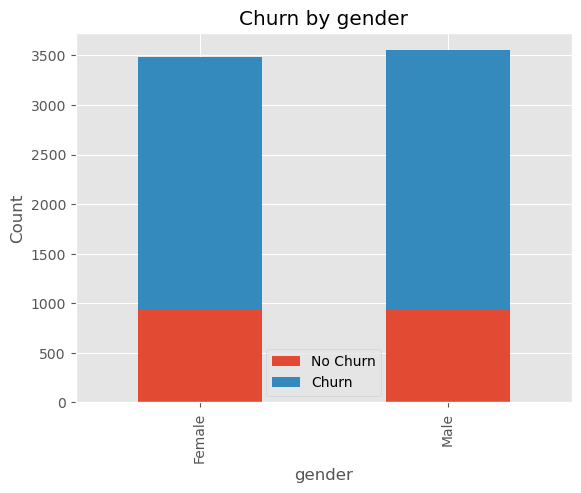

<Figure size 800x600 with 0 Axes>

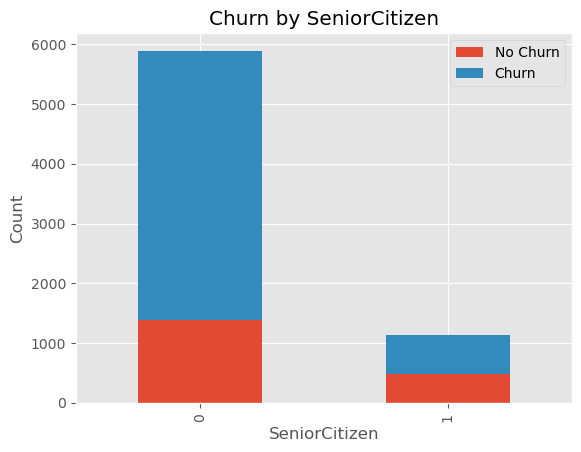

<Figure size 800x600 with 0 Axes>

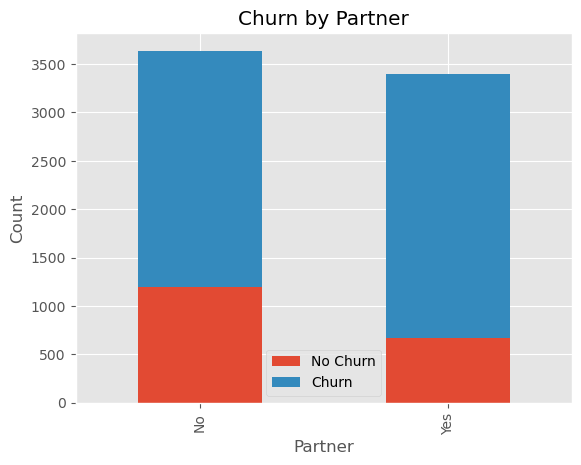

<Figure size 800x600 with 0 Axes>

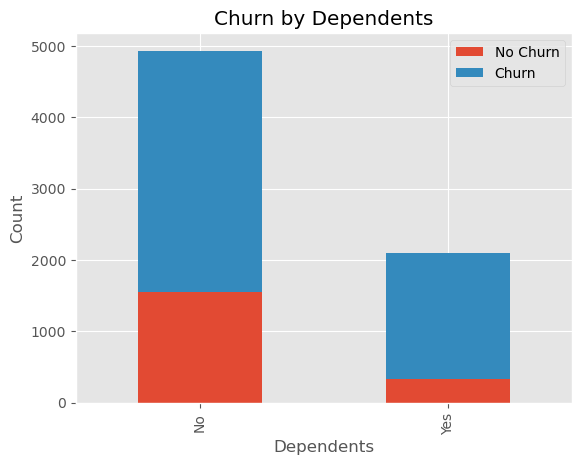

<Figure size 800x600 with 0 Axes>

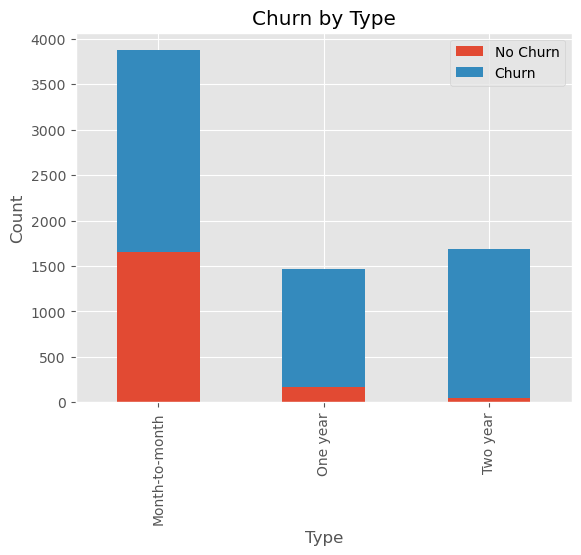

<Figure size 800x600 with 0 Axes>

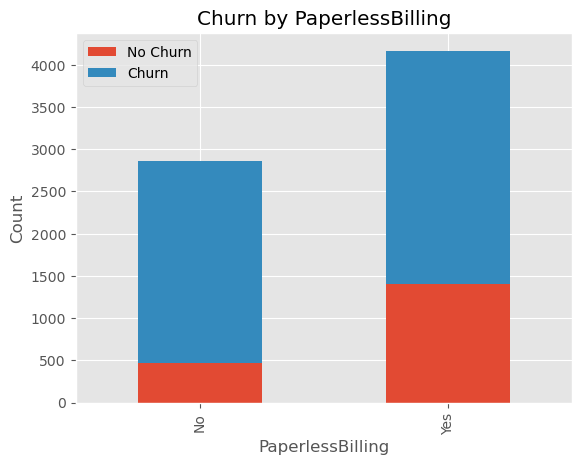

<Figure size 800x600 with 0 Axes>

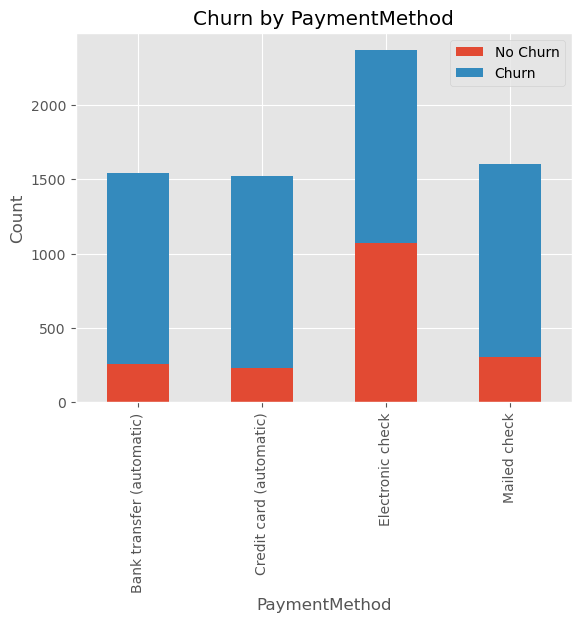

<Figure size 800x600 with 0 Axes>

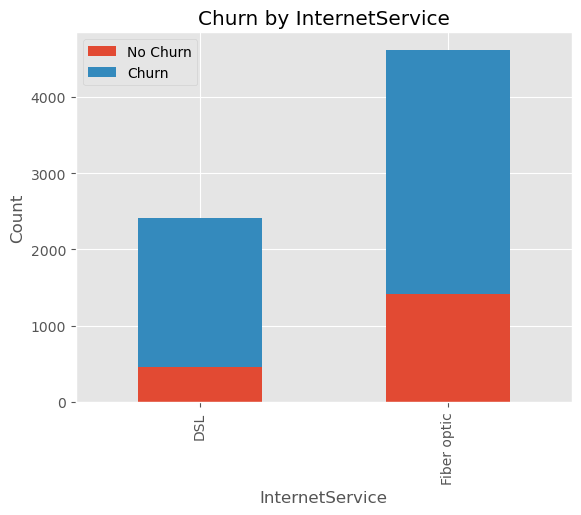

<Figure size 800x600 with 0 Axes>

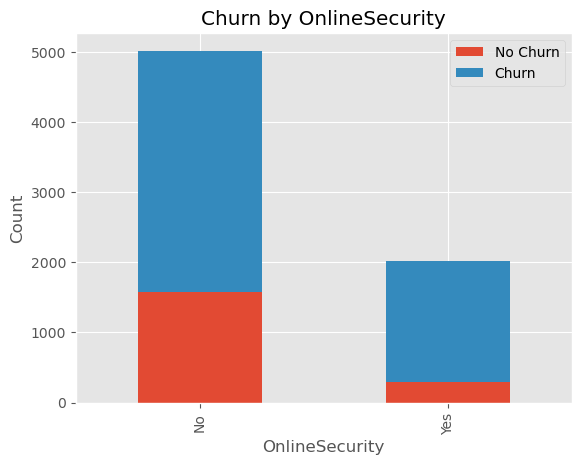

<Figure size 800x600 with 0 Axes>

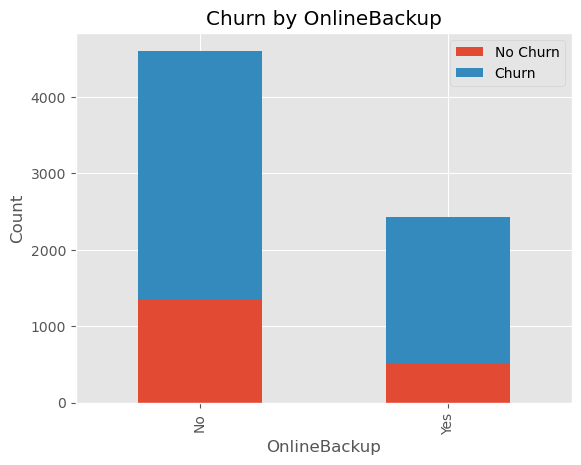

<Figure size 800x600 with 0 Axes>

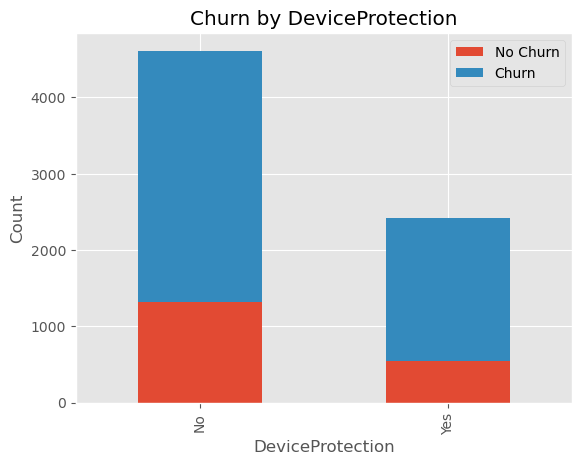

<Figure size 800x600 with 0 Axes>

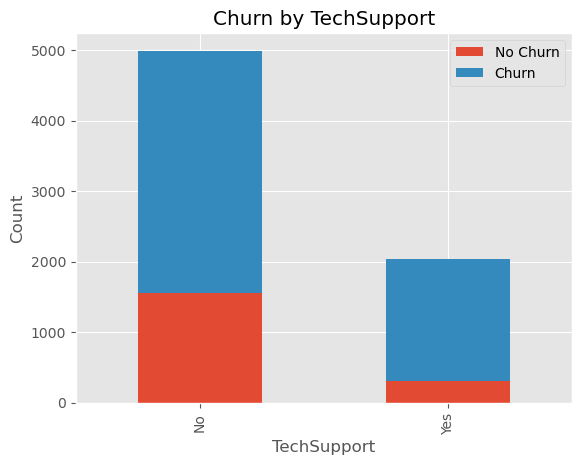

<Figure size 800x600 with 0 Axes>

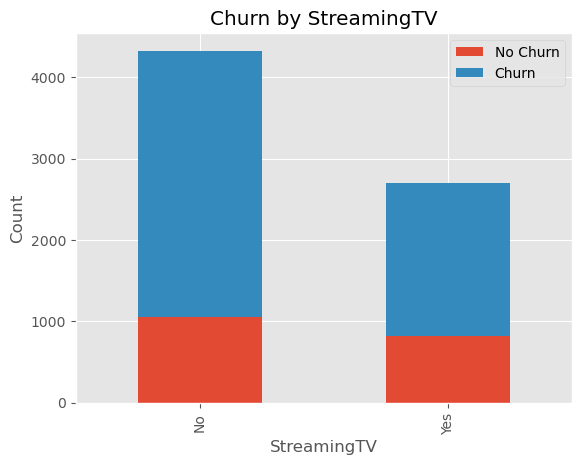

<Figure size 800x600 with 0 Axes>

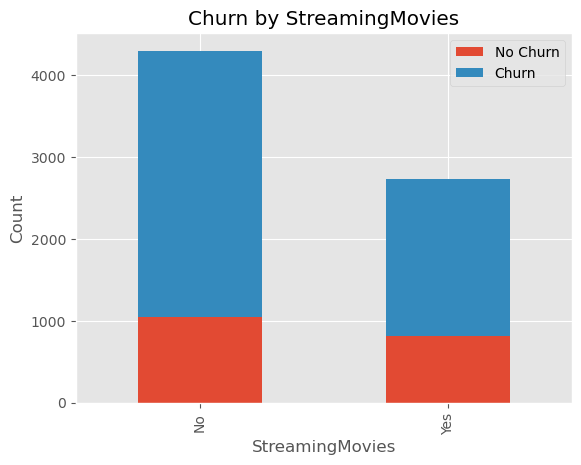

<Figure size 800x600 with 0 Axes>

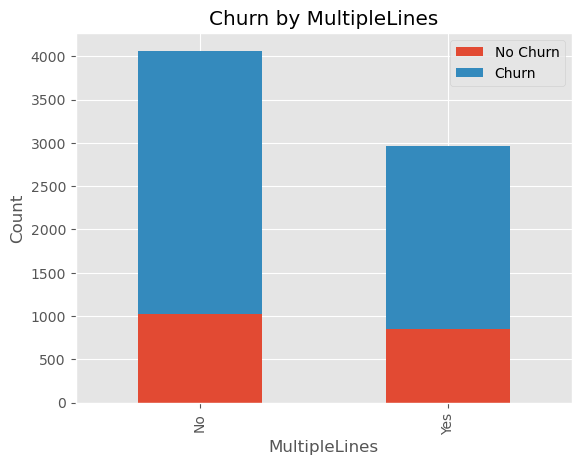

In [40]:
# Список признаков для визуализации
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod',
            'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies', 'MultipleLines']

# Создаем столбчатые диаграммы для каждого признака
for feature in features:
    plt.figure(figsize=(8, 6))
    merged_df.groupby([feature, 'Churn']).size().unstack().plot(kind='bar', stacked=True)
    plt.title(f'Churn by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(['No Churn', 'Churn'])
    plt.show()

#### Дадим краткое описание:
 - Gender: Отток клиентов примерно одинаков между мужчинами и женщинами. Это говорит о том, что пол, вероятно, не играет значительной роли в оттоке клиентов.

- SeniorCitizen: Среди пожилых граждан отток клиентов меньше, чем среди остальной части населения.

- Partner: Клиенты, не являющиеся супругами, склонны к большему оттоку, чем те, кто являются семьей.

- Dependents: Клиенты, не имеющие детей, чаще становятся объектами оттока, чем те, у кого они есть.

- Type: Клиенты с ежемесячными контрактами склонны к более высокому оттоку, чем те, у кого годовые или двухгодичные контракты.

- PaperlessBilling: Клиенты, использующие электронный расчётный лист, более склонны к оттоку.

- PaymentMethod: Клиенты, использующие электронный чек для оплаты, склонны к большему оттоку.

- InternetService: Клиенты, пользующиеся оптоволоконным интернетом, более склонны к оттоку, чем те, у кого DSL.

- OnlineSecurity, OnlineBacku, DeviceProtection, TechSupport: Клиенты, не использующие эти услуги, более склонны к оттоку.

- StreamingTV и StreamingMovies: Клиенты, не использующие стриминговые услуги, более склонны к оттоку, но разница не такая большая, как с другими услугами.

- MultipleLines: Распределение оттока примерно одинаковое между пользователями с несколькими линиями и теми, у кого их нет.

### Корреляционный анализ

Для числовых признаков коэффициент корреляции определяет степень линейной связи между двумя переменными.

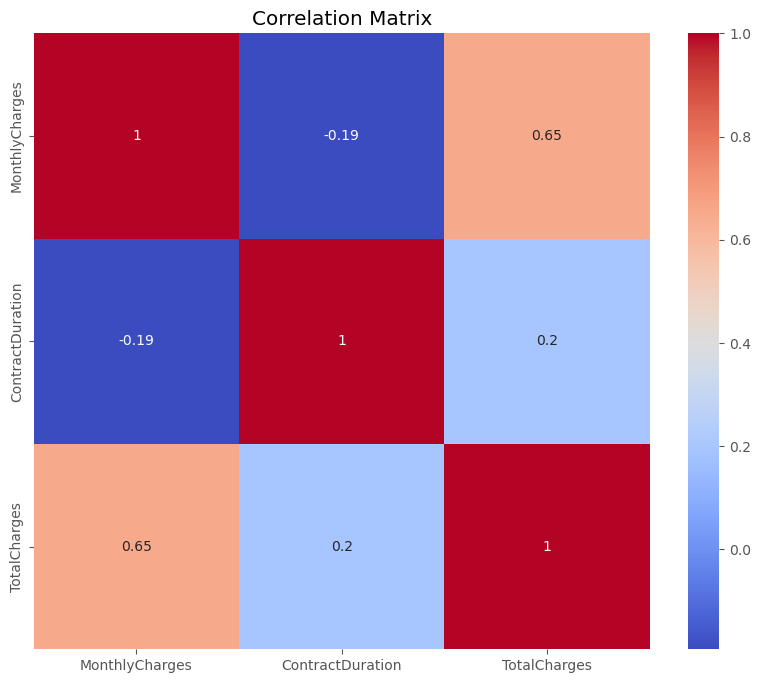

In [41]:
# Выбираем только числовые признаки
numeric_features = ['MonthlyCharges', 'ContractDuration', 'TotalCharges']

# Создаем матрицу корреляций
corr_matrix = merged_df[numeric_features].corr()

# Создаем тепловую карту для визуализации корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

#### краткое описание коэффициента корреляции для числовых признаков
- MonthlyCharges и TotalCharges: Эти два признака имеют сильную положительную корреляцию (~0.65), что означает, что общие затраты клиента увеличиваются с увеличением ежемесячных платежей. Это вполне логично, так как чем больше клиент платит в месяц, тем больше он тратит в общем.

Для анализа корреляции между категориальными переменными воспользуемся коэффициентом корреляции Крамера

In [42]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Применяем функцию для каждой пары категориальных переменных в вашем датафрейме
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 
                        'PaymentMethod', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
                        'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

cramers_results = pd.DataFrame(index=categorical_features, columns=categorical_features)

for col1 in categorical_features:
    for col2 in categorical_features:
        cramers_results.loc[col1, col2] = cramers_v(merged_df[col1], merged_df[col2])

# Выводим получившиеся результаты
cramers_results


,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
gender,0.999716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010687,0.004632,0.0,0.0,0.0,0.0,0.0
SeniorCitizen,0.0,0.999477,0.011506,0.209805,0.142177,0.15542,0.194411,0.107216,0.036241,0.06518,0.057897,0.058962,0.104377,0.118858,0.142116
Partner,0.0,0.011506,0.999715,0.451833,0.294869,0.006676,0.162568,0.0,0.142543,0.141057,0.152803,0.119306,0.123625,0.117219,0.141783
Dependents,0.0,0.209805,0.451833,0.99966,0.241117,0.109173,0.147969,0.049863,0.079559,0.020032,0.00648,0.061571,0.010934,0.036142,0.02082
Type,0.0,0.142177,0.294869,0.241117,1.0,0.175691,0.265958,0.064205,0.251065,0.163954,0.22757,0.296279,0.11132,0.116699,0.10905
PaperlessBilling,0.0,0.15542,0.006676,0.109173,0.175691,0.999705,0.246813,0.061952,0.0,0.126198,0.103094,0.035257,0.223642,0.210964,0.163029
PaymentMethod,0.0,0.194411,0.162568,0.147969,0.265958,0.246813,1.0,0.103632,0.174008,0.187836,0.204346,0.180188,0.252522,0.253304,0.226983
InternetService,0.0,0.107216,0.0,0.049863,0.064205,0.061952,0.103632,0.999685,0.319813,0.156006,0.144353,0.311647,0.008536,0.022332,0.199673
OnlineSecurity,0.010687,0.036241,0.142543,0.079559,0.251065,0.0,0.174008,0.319813,0.999652,0.282722,0.274304,0.353936,0.174797,0.186736,0.097554
OnlineBackup,0.004632,0.06518,0.141057,0.020032,0.163954,0.126198,0.187836,0.156006,0.282722,0.999685,0.302529,0.293153,0.281061,0.273976,0.201587


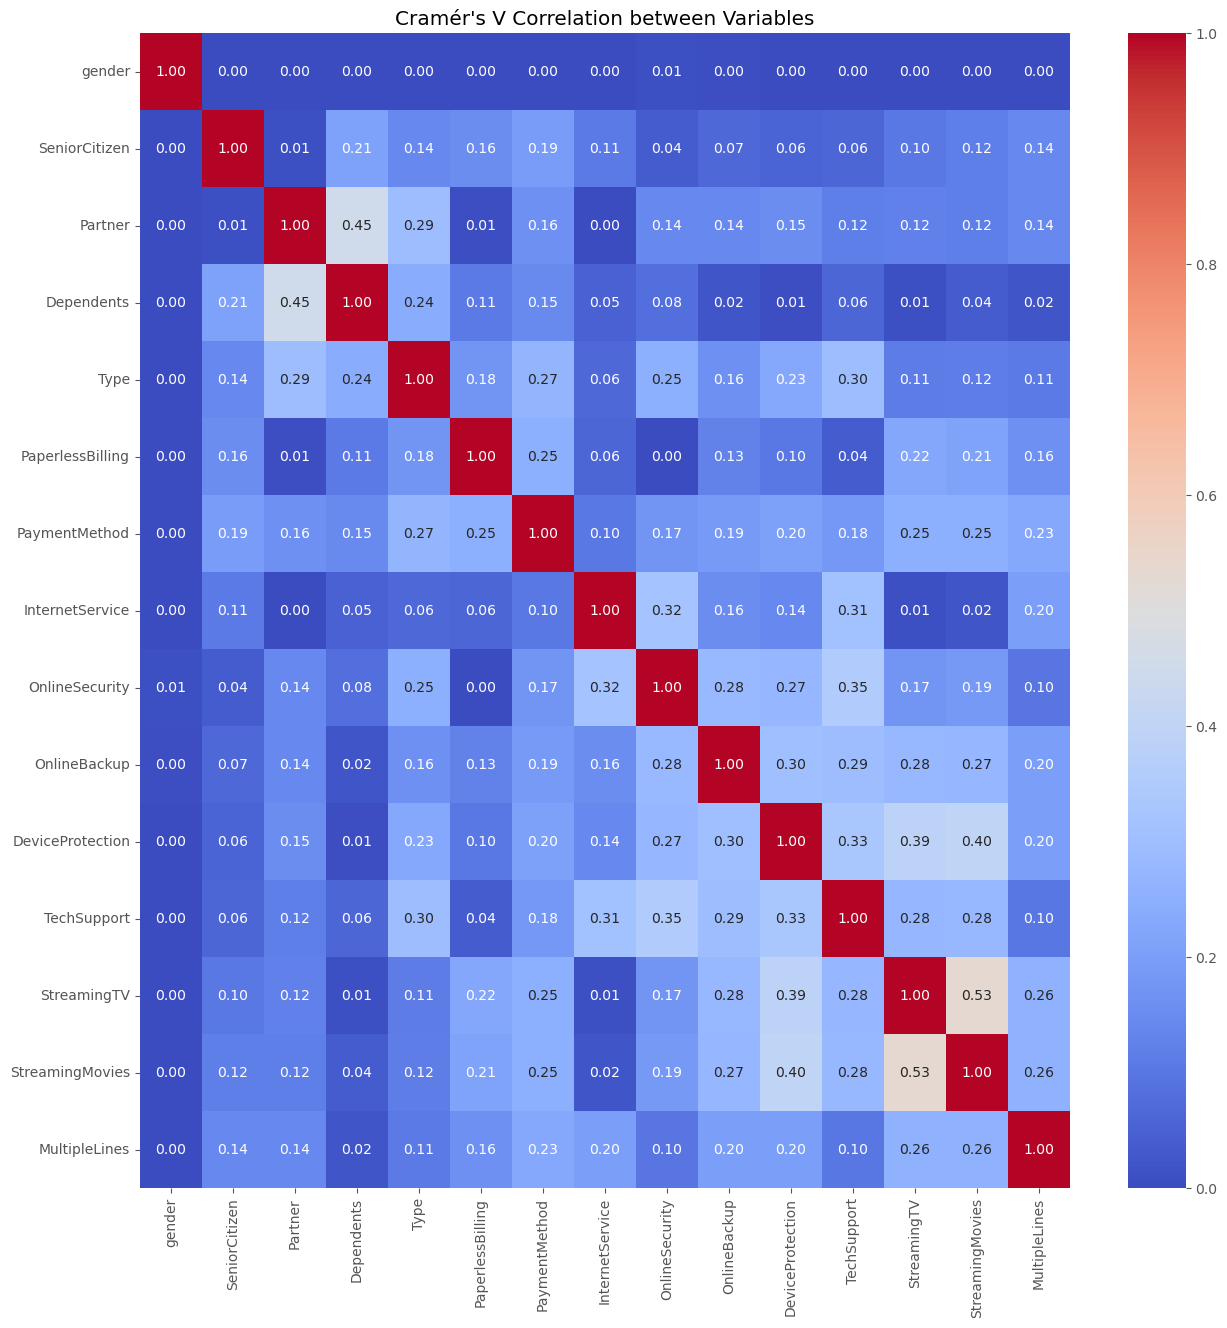

In [43]:
plt.figure(figsize=(15, 15))
sns.heatmap(cramers_results.astype(float), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Cramér's V Correlation between Variables")
plt.show()

#### краткое описание коэффициента корреляции для категориальных признаков
- gender показывает очень низкую ассоциацию со всеми другими переменными, что указывает на то, что пол не имеет сильного влияния на другие характеристики в данных.

- SeniorCitizen и Dependents имеют небольшую ассоциацию (0.21). Это может указывать на то, что пожилые клиенты чаще имеют детей, что логично.

- Partner и Dependents имеют сильную ассоциацию (0.45), что может указывать на то, что семейные пары - клиенты чаще имеют детей, что так же не противоречит логике.

 - Type имеет небольшую ассоциацию с TechSupport (0.3). Это может говорить о том, что тип оплаты контракта влияет на то, используют ли клиенты техническую поддержку или нет.

 - DeviceProtection имеет сильные ассоциации с StreamingTV (0.4) и StreamingMovies (0.4), что может указывать на то, что клиенты, которые используют защиту устройств, чаще используют услуги потокового просмотра.

- StreamingTV и StreamingMovies имеют очень сильную ассоциацию (0.532985), что говорит о том, что клиенты, которые смотрят потоковое телевидение, также склонны смотреть потоковые фильмы.

### Подготовим данные для обучения и выберем признаки, которые будем использовать для обучения

Разберем следующие признаки и посмотрим какие оставим :

customerID: Идентификатор клиента. Этот признак не несет полезной информации для обучения модели. Удаляем.

BeginDate: Дата начала контракта клиента. Этот признак является датой и не будет использоваться как входной признак модели. Удаляем.

EndDate: Дата окончания контракта клиента. Этот признак является датой и не будет использоваться как входной признак модели. Удаляем.

Все остальные признаки оставляем

In [44]:
# Удалим ненужные признаки
merged_df = merged_df.drop(['customerID', 'BeginDate', 'EndDate'], axis=1)

In [45]:
merged_df.head()

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration,HasPhoneService,HasInternetService,Churn
0,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,...,Yes,No,No,No,No,No,1526.0,1,1,1
1,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,DSL,...,No,Yes,No,No,No,No,1560.0,0,1,1
2,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,...,Yes,No,No,No,No,No,479.0,0,1,0
3,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,...,No,Yes,Yes,No,No,No,1654.0,1,1,1
4,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,...,No,No,No,No,No,No,279.0,0,1,0


In [46]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7032 non-null   object 
 1   SeniorCitizen       7032 non-null   object 
 2   Partner             7032 non-null   object 
 3   Dependents          7032 non-null   object 
 4   Type                7032 non-null   object 
 5   PaperlessBilling    7032 non-null   object 
 6   PaymentMethod       7032 non-null   object 
 7   MonthlyCharges      7032 non-null   float64
 8   TotalCharges        7032 non-null   float64
 9   InternetService     7032 non-null   object 
 10  OnlineSecurity      7032 non-null   object 
 11  OnlineBackup        7032 non-null   object 
 12  DeviceProtection    7032 non-null   object 
 13  TechSupport         7032 non-null   object 
 14  StreamingTV         7032 non-null   object 
 15  StreamingMovies     7032 non-null   object 
 16  Multip

In [47]:
# Проверим на дисбаланс классов у целевого признака
merged_df['Churn'].value_counts(normalize=True)

1    0.734215
0    0.265785
Name: Churn, dtype: float64

#### Разделим данные на тренировочную и тестовую выборки (test_size = 0.25)

In [48]:
# Разделение на признаки (X) и целевую переменную (y)
X = merged_df.drop('Churn', axis=1)
y = merged_df['Churn']

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    shuffle=True,
                                                    stratify=y, 
                                                    random_state=RANDOM_STATE)

print(X_train.shape, y_train.shape,
      X_test.shape, y_test.shape)

(5274, 20) (5274,) (1758, 20) (1758,)


In [49]:
# масштабирование числовых признаков и кодирование категориальных признаков

numerics = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical = X_train.select_dtypes(include='object').columns

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

X_train_copy = X_train
X_test_copy = X_test

col_transformer.fit(X_train_copy)
X_train = col_transformer.transform(X_train_copy)
X_test = col_transformer.transform(X_test_copy)

In [50]:
print(f'Доля тренировочных признаков: {X_train.shape[0]/merged_df.shape[0]:.2f}')
print(f'Доля тренировочных целей: {y_train.shape[0]/merged_df.shape[0]:.2f}')
print(f'Доля тестовых признаков: {X_test.shape[0]/merged_df.shape[0]:.2f}')
print(f'Доля тестовых целей: {y_test.shape[0]/merged_df.shape[0]:.2f}')
print(f'Доля положительных целей на тренировочных данных: {y_train.astype("int").mean():.2f}')
print(f'Доля положительных целей на тестовых данных: {y_test.astype("int").mean():.2f}')

Доля тренировочных признаков: 0.75
Доля тренировочных целей: 0.75
Доля тестовых признаков: 0.25
Доля тестовых целей: 0.25
Доля положительных целей на тренировочных данных: 0.73
Доля положительных целей на тестовых данных: 0.73


In [51]:
X_train[:5]

array([[ 0.33699844, -0.69272717,  0.52736684, -1.02768689,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-1.46370404, -0.97088841,  0.58856101, -1.02768689,  0.        ,
         1.        ,  0.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.50454421, -0.65267477,  0.71274919, -1.02768689,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.    

In [52]:
X_test[:5]

array([[ 0.37675637, -0.86444961, -1.52803742,  0.97305902,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ],
       [ 0.98472123,  1.69716139,  0.66775347, -1.02768689,  0.        ,
         0.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  1.        ,  0.        ],
       [ 1.12718711,  1.5588527 , -1.73681753,  0.97305902,  0.        ,
         1.        ,  1.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
         1.        ,  1.    

## Обучение моделей

### RandomForestClassifier

In [53]:
# Создадим pipeline для классификатора RandomForestClassifier().
pipe_rf = Pipeline([
    ('classifier', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced',
        verbose=0
    ))
])

In [54]:
# Зададим сетку параметров и создадим estimator.
param_grid = {
    'classifier__n_estimators': np.arange(1, 4, 10),
    'classifier__max_depth': np.arange(2, 5, 10),
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 5],
    'classifier__criterion': ['gini', 'entropy'],
}

gs_rf = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [55]:
# Проведём обучение с кросс-валидацией выбранного оценщика.
%time 

gs_rf.fit(X_train, y_train)  # Обучение модели с кросс-валидацией

best_model = gs_rf.best_estimator_  # Получение лучшей модели
importances = best_model.named_steps['classifier'].feature_importances_  # Получение важности признаков


CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 1.91 µs
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [56]:
# Оценка качества модели с помощью функции cross_val_score
scores_gs_rf = cross_val_score(
    gs_rf.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc'
)
final_score_gs_rf = sum(scores_gs_rf) / len(scores_gs_rf)
print('Средняя оценка качества модели:', final_score_gs_rf)


Средняя оценка качества модели: 0.9756127989017251


### LGBMClassifier

In [57]:
# Создадим pipeline для классификатора LightGBM
pipe_gbm = make_pipeline(
    lgb.LGBMClassifier(
        objective='binary',
        metric='roc_auc',
        n_jobs=-1,
        verbosity=-1,
        random_state=RANDOM_STATE
    )
)

In [58]:
param_grid = {
    'lgbmclassifier__n_estimators': np.arange(10, 20, 50),
    'lgbmclassifier__max_depth': [-1, 5, 7],
    'lgbmclassifier__min_child_samples': [10, 30, 50],
    'lgbmclassifier__learning_rate': [0.1, 0.5, 0.7], 
}

gs_gbm = GridSearchCV(
    pipe_gbm,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [59]:
# Проведём обучение с кросс-валидацией выбранного оценщика.
%time 

scores_gs_gbm = cross_val_score(gs_gbm, X_train, y_train, cv=5, scoring='roc_auc')
final_score_gs_gbm = sum(scores_gs_gbm)/len(scores_gs_gbm)
print('Средняя оценка качества модели:', final_score_gs_gbm)


CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 µs
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Средняя оценка качества модели: 1.0


### XGBClassifier

In [60]:
# Создадим pipeline для классификатора XGBClassifier
pipe_xgb = make_pipeline(
    XGBClassifier(
        objective='binary:logistic',
        random_state=RANDOM_STATE
    )
)

In [61]:
param_grid = {
    'xgbclassifier__n_estimators': [30], 
    'xgbclassifier__max_depth': [-1, 5, 7],
    'xgbclassifier__learning_rate': [0.1, 0.5, 0.9], 
    'xgbclassifier__reg_alpha': [0.1],
    'xgbclassifier__reg_lambda': [0.1]
}

gs_xgb = GridSearchCV(
    pipe_xgb,
    param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

In [62]:
# Проведём обучение с кросс-валидацией выбранного оценщика.
%time 

scores_gs_xgb = cross_val_score(gs_xgb, X_train, y_train, cv=5, scoring='roc_auc')
final_score_gs_xgb = sum(scores_gs_xgb)/len(scores_gs_xgb)
print('Средняя оценка качества модели:', final_score_gs_xgb)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 2.86 µs
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Средняя оценка качества модели: 1.0


### Модель полносвязной нейронной сети (MLP)

In [63]:
# Создание модели MLP
model_mlp = Sequential()

# Добавление слоев
model_mlp.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1])) # Входной слой
model_mlp.add(Dropout(0.5)) # Dropout для регуляризации
model_mlp.add(Dense(units=32, activation='relu')) # Скрытый слой
model_mlp.add(Dropout(0.5)) # Dropout для регуляризации
model_mlp.add(Dense(units=1, activation='sigmoid')) # Выходной слой

optimizer = Adam(learning_rate=0.00001)

# Компиляция модели
model_mlp.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve='ROC')])

# Обучение модели
model_mlp.fit(X_train,
          y_train,
          epochs=10,
          batch_size=32,
          validation_data=(X_test, y_test),
          shuffle=True,
          verbose=2)

Epoch 1/10


2023-07-03 19:59:52.384822: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


165/165 - 0s - loss: 0.8284 - auc: 0.4954 - val_loss: 0.7364 - val_auc: 0.5422 - 426ms/epoch - 3ms/step
Epoch 2/10
165/165 - 0s - loss: 0.7988 - auc: 0.5068 - val_loss: 0.7123 - val_auc: 0.5744 - 72ms/epoch - 439us/step
Epoch 3/10
165/165 - 0s - loss: 0.7840 - auc: 0.5133 - val_loss: 0.6904 - val_auc: 0.6064 - 68ms/epoch - 414us/step
Epoch 4/10
165/165 - 0s - loss: 0.7561 - auc: 0.5281 - val_loss: 0.6703 - val_auc: 0.6379 - 69ms/epoch - 417us/step
Epoch 5/10
165/165 - 0s - loss: 0.7375 - auc: 0.5470 - val_loss: 0.6523 - val_auc: 0.6666 - 68ms/epoch - 413us/step
Epoch 6/10
165/165 - 0s - loss: 0.7078 - auc: 0.5693 - val_loss: 0.6355 - val_auc: 0.6941 - 67ms/epoch - 408us/step
Epoch 7/10
165/165 - 0s - loss: 0.7002 - auc: 0.5641 - val_loss: 0.6199 - val_auc: 0.7198 - 68ms/epoch - 411us/step
Epoch 8/10
165/165 - 0s - loss: 0.6900 - auc: 0.5731 - val_loss: 0.6054 - val_auc: 0.7430 - 68ms/epoch - 412us/step
Epoch 9/10
165/165 - 0s - loss: 0.6700 - auc: 0.5973 - val_loss: 0.5916 - val_auc: 0

In [64]:
final_score__mlp = 0.8138

Посмотрим на обобщающий результат

,model,ROC-AUC
0,RandomForestClassifier,0.975613
1,LGBMClassifier,1.000000
2,XGBClassifier,1.000000
3,MLP,0.813800


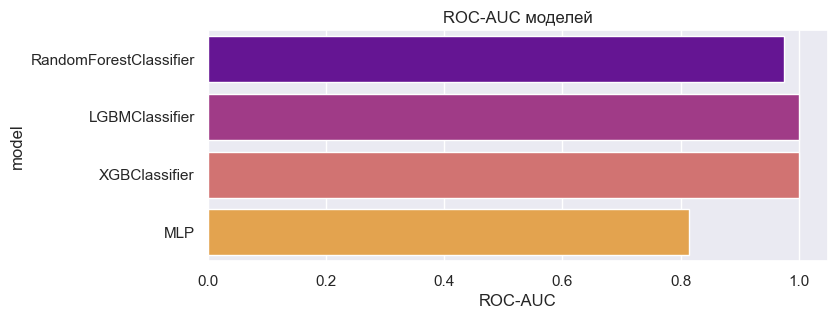

In [65]:
# Создаем список моделей
models = ['RandomForestClassifier', 'LGBMClassifier', 'XGBClassifier', 'MLP']

# Создаем список результатов
results = [final_score_gs_rf, final_score_gs_gbm, final_score_gs_xgb, final_score__mlp]  # Здесь вам нужно заменить score_model1 и т.д. на фактические оценки каждой модели

v = pd.DataFrame({'model': models, 'ROC-AUC': results})

sns.set (font_scale= 1)
plt.figure(figsize=[8,3])
plt.title('ROC-AUC моделей')
ax = sns.barplot(x='ROC-AUC', y="model", data=v, palette='plasma')
v

### Вывод: 
можно заметить, что бустинговые модели переобучаются. Из 2 оставщихся RandomForestClassifier показал лучший результат (значение метрики ROC-AUC = 0.975613). Это говорит о том, что модель хорошо классифицирует данные и имеет высокую способность разделять классы. Значит и тестировать будем эту модель


### Тестирование RandomForestClassifier

In [66]:
%time 

prediction_gs_rf = gs_rf.predict(X_test)
auc_roc = roc_auc_score(y_test, prediction_gs_rf)
accuracy = accuracy_score(y_test, prediction_gs_rf)

print("AUC-ROC:", auc_roc)
print("Accuracy:", accuracy)

CPU times: user 9 µs, sys: 24 µs, total: 33 µs
Wall time: 9.3 µs
AUC-ROC: 0.9186726754321218
Accuracy: 0.931740614334471


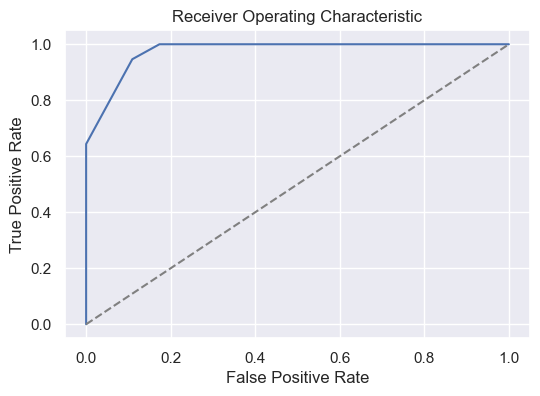

In [67]:
from sklearn.metrics import roc_curve

# Вычисление вероятностей принадлежности к положительному классу
y_pred = gs_rf.best_estimator_.predict_proba(X_test)[:, 1]

# Вычисление значения FPR (False Positive Rate), TPR (True Positive Rate) и порогов
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Построение кривой AUC-ROC
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()


В целом, результаты указывают на то, что модель показывает хорошую производительность с высоким значением AUC-ROC (0,92) и достаточно высокой точностью (93,2%).

### Матрица ошибок лучшей модели

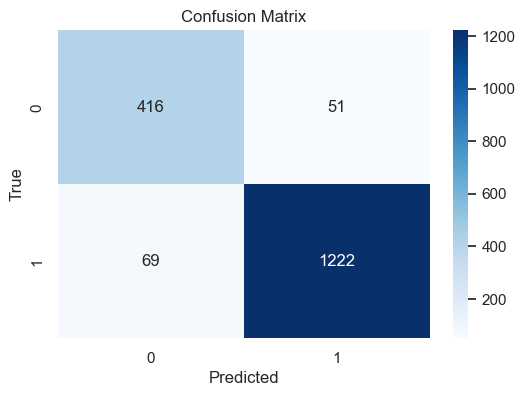

In [68]:
# Вычисление предсказаний лучшей модели на тестовых данных
y_pred = gs_rf.best_estimator_.predict(X_test)

# Вычисление матрицы ошибок
cm = confusion_matrix(y_test, y_pred)

# Вычисление полноты и точности модели
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Построение матрицы ошибок
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

- True Positives (TP): 416. Модель правильно предсказала, что эти клиенты уйдут (отток).

- True Negatives (TN): 1222. Модель правильно предсказала, что эти клиенты останутся (не уйдут).

- False Positives (FP): 69. Модель предсказала, что эти клиенты уйдут, но они остались.

- False Negatives (FN): 51. Модель предсказала, что эти клиенты останутся, но они ушли.

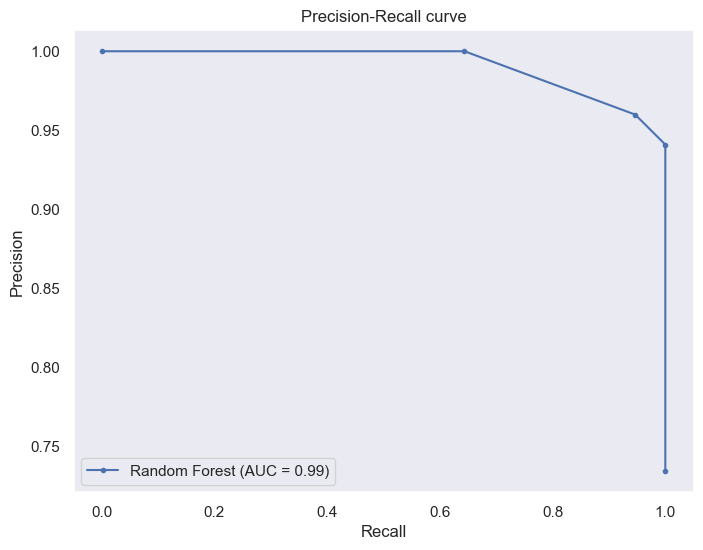

In [69]:
# Вычисление вероятностей классов с помощью предсказательной модели
probs = gs_rf.best_estimator_.predict_proba(X_test)

# Вычисление PR-кривой
precision, recall, _ = precision_recall_curve(y_test, probs[:, 1])

# Вычисление площади под PR-кривой
pr_auc = auc(recall, precision)

# Отображение PR-кривой на графике
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='Random Forest (AUC = %0.2f)' % pr_auc)
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

### Анализ важность основных входных признаков, влияющих на отток клиентов.

Анализ важности основных входных признаков, влияющих на отток клиентов, можно выполнить с использованием атрибута feature_importances_ лучшей модели, полученной при обучении RandomForestClassifier.

In [70]:
X_train_transformed = col_transformer.transform(X_train_copy)  # Преобразованные данные
feature_names = list(X_train_copy.columns)  # Список имен признаков из исходных данных
importances = best_model.named_steps['classifier'].feature_importances_  # Важности признаков
  
    # Создание списка признаков с их важностью
feature_importances = list(zip(feature_names, importances))

# Сортировка списка по важности (от наибольшей к наименьшей)
sorted_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Вывод отсортированного спискаb
for feature_name, importance in sorted_importances:
    print(f"{feature_name}: {importance}")

Partner: 0.9307511389109744
TotalCharges: 0.053118492288660016
SeniorCitizen: 0.01613036880036557
gender: 0.0
Dependents: 0.0
Type: 0.0
PaperlessBilling: 0.0
PaymentMethod: 0.0
MonthlyCharges: 0.0
InternetService: 0.0
OnlineSecurity: 0.0
OnlineBackup: 0.0
DeviceProtection: 0.0
TechSupport: 0.0
StreamingTV: 0.0
StreamingMovies: 0.0
MultipleLines: 0.0
ContractDuration: 0.0
HasPhoneService: 0.0
HasInternetService: 0.0


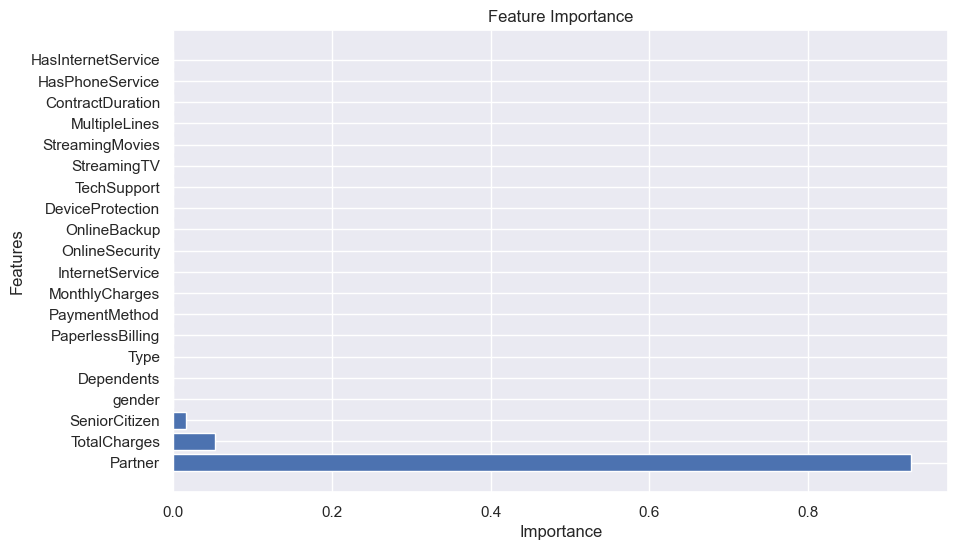

In [71]:
# Разделение признаков и их важностей на отдельные списки
sorted_features, sorted_scores = zip(*sorted_importances)

# Построение графика важности признаков
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_scores)), sorted_scores, align='center')
plt.yticks(range(len(sorted_scores)), sorted_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

Как видно самым важным фактором, влияющим на отток клиентов является наличие супруга  

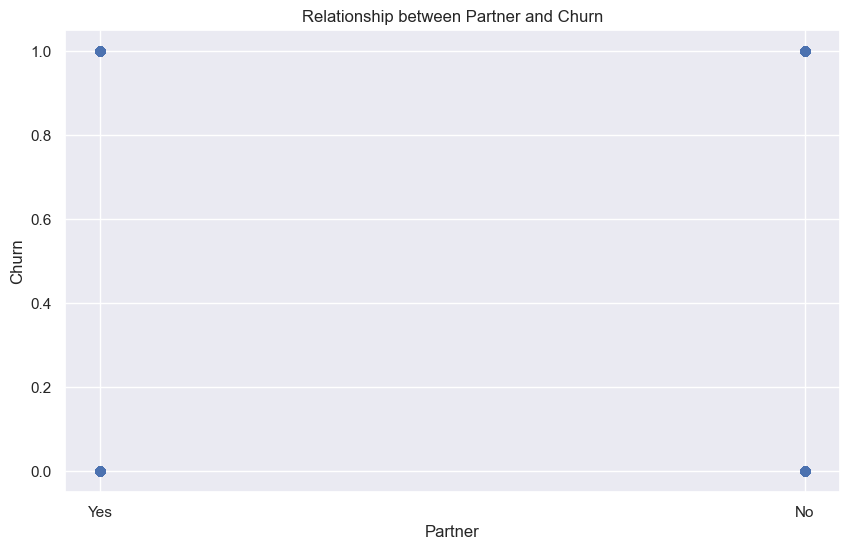

In [72]:
# Создание графика
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['Partner'], merged_df['Churn'], alpha=0.5)
plt.xlabel('Partner')
plt.ylabel('Churn')
plt.title('Relationship between Partner and Churn')
plt.show()

Поясним:
(0, 0): Эта точка означает, что у клиентов, у которых нет супруга (значение "Partner" = 0) и значение целевого признака (отток клиентов) = 0. Т.е. клиенты, которые не имеют супруга, проявляют более высокую лояльность (реже уходят) и остаются клиентами.

(1, 0): Здесь "Partner" = 1 (есть супруг), "Churn" = 0 - так же предпочитают оставаться клиентами компании.

(0, 1): "Partner" = 0 (нет супруга), "Churn" = 1 (есть отток клиентов). Это может указывать на то, что отсутствие партнера может быть связано с повышенным риском оттока клиентов.

(1, 1): Точка "Partner" = 1 (есть партнер), "Churn" = 1 указывает на то, что наличие партнера не является гарантией оставаться котентом компании.

В целом, наличие супруга (значение "Partner" равно 1) может быть связано с более высокой лояльностью и стабильностью клиентов, но это не является единственным фактором, определяющим отток клиентов.

### Вывод
На 1-ом этапе подключили базу данных. Оказалось, что есть еще таблицы, не считая тех 4 указанных в описании. Скорее всего это административные таблицы и нас они не интересуют. Поэтому работать  продолжали только с contract; personal; internet; phone.

Был проведем исследовательский анализ и предобработка данных. Были выявлены пропуски (в таблице contract), был определен перечень наименований для замены типа данных. Добавили 3 новых переменных: 'ContractDuration' (Расчет длительности контракта), 'HasPhoneService'(указывающий, есть ли у клиента услуга стационарной телефонной связи), 'HasInternetService' (указывающий, есть ли у клиента услуга интернета) и все таблицы объединили в одну, при этом удалили или заменили все пропуски.
Признаки разделили на train и test, масштабировали числовые признаки и кодировали категориальные признаки.

При обучении моделей можно заметить, что бустинговые модели переобучаются. Из 2 оставщихся RandomForestClassifier и Модель полносвязной нейронной сети, лес показал лучший результат (значение метрики ROC-AUC = 0.975613). Это говорит о том, что модель хорошо классифицирует данные и имеет высокую способность разделять классы.

На тестировании модель показывает хорошую производительность с высоким значением AUC-ROC (0,92) и высокой точностью (93,2%).
Модель правильно предсказала, что 416 клиентов уйдут (отток) и 1222 клиента останутся (не уйдут), что составляет примерно 88% и 91% соответственно от общего числа клиентов.
Самым важным фактором, влияющим на отток клиентов, как выясгилось, является наличие супруга. При дальнейшем исследовании можно отметить что, наличие супруга может быть связано с более высокой лояльностью и стабильностью клиентов, но это не является единственным фактором, определяющим отток клиентов.

### Cпособы для дальнейшего улучшения модели:

- Увеличение объема данных: Для более точного обучения модели рекомендуется собрать больше данных о клиентах и их поведении. Чем больше информации у нас будет о клиентах, тем лучше модель сможет их классифицировать.

- Улучшение признаков: Дополнительные исследования и анализ могут помочь выявить новые полезные признаки или преобразовать существующие признаки, чтобы они лучше соответствовали поведению клиентов.

### Бизнес-рекомендации заказчику:

- Используйте предсказания модели для идентификации клиентов с высоким риском оттока. Особое внимание следует обратить на клиентов без супруга, так как они проявляют повышенный отток. Разработайте специальные предложения и промокоды, которые будут предлагаться таким клиентам с целью удержания и повышения их лояльности.

- Проводите дополнительные исследования и анализ для определения образования более точных прогнозов и разработки индивидуальных стратегий удержания для различных групп клиентов.

- Постоянно мониторьте и изучайте поведение клиентов и факторы, влияющие на отток, чтобы оперативно реагировать и принимать меры для удержания клиентов. Регулярно обновляйте модель с новыми данными, чтобы она была актуальной и точной.